In [43]:
import numpy as np
import pandas as pd
import os
import cv2                      #pip install opencv-python
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img
from keras.layers import Dense
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow.keras.optimizers import Adadelta, Adagrad, Adam, SGD
from keras.datasets import mnist
#import sklearn.metrics as metrics
from tensorflow.keras import models, layers, optimizers, losses, metrics
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score 
from sklearn.dummy import DummyClassifier
import datetime

original_start = datetime.datetime.now()
start = datetime.datetime.now()

# Function for visualization training results


### Reasons to Visualize
- To evaluate the Underfitting or Overfitting
- To adjust the Hyperparameters
- To visualize metrics

In [57]:


def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_recall'], label = 'Validation Recall')
    plt.plot(history['recall'], label = 'Train Recall')
    plt.title('Recall Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.show();
    


## Loading Data


- The dataset, the validation data was very small in number i.e. Therefore, we did a 80-20 split on the train dataset to use an alternative set of images for validation.

In [45]:

train_datagen = ImageDataGenerator(
        rescale=1./255, validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
         "DATASET/TRAIN",
        target_size=(150, 150),
        color_mode='rgba',
        batch_size=32,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        "DATASET/TRAIN",
        target_size=(150, 150),
        color_mode='rgba',
        batch_size=32,
        class_mode='categorical',
        subset='validation')


Found 866 images belonging to 5 classes.
Found 215 images belonging to 5 classes.


In [46]:

yoga_test = test_datagen.flow_from_directory("DATASET/TEST",
        target_size=(150, 150),
        color_mode='rgba',                                     
        batch_size=32,
        class_mode='categorical',
        shuffle=False                                     
        )
                                            
                                            

Found 470 images belonging to 5 classes.


# Data Augmentation

- Data augmentation is typically always a necessary step when using a small dataset as this one. If you haven't already, implement a data augmentation setup.



In [47]:
train_datagen_aug = ImageDataGenerator(
        zoom_range=0.2, # zoom
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,# horizontal flip
        vertical_flip=True,
        rotation_range=40,
        #shear_range=0.2,
        rescale=1./255, validation_split=0.20)

train_generator_aug = train_datagen_aug.flow_from_directory(
         "DATASET/TRAIN",
        target_size=(150, 150),
        color_mode='rgba',
        batch_size=32,
        class_mode='categorical',
        subset='training',
        seed=7)

validation_datagen_aug = ImageDataGenerator(
        rescale=1./255, validation_split=0.20)

validation_generator_aug = validation_datagen_aug.flow_from_directory(
        "DATASET/TRAIN",
        target_size=(150, 150),
        color_mode='rgba',
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        seed=7)


Found 866 images belonging to 5 classes.
Found 215 images belonging to 5 classes.


In [65]:
#create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(validation_generator)


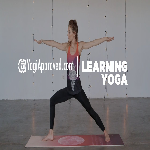

In [313]:
#exploring and inspecting some images 
array_to_img(train_images[9])

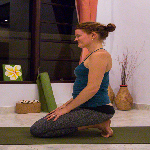

In [288]:
array_to_img(train_images[12])

In [289]:
# tried different index and missed out of bounds so will have to see the shape
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))


(32, 150, 150, 4)
(32, 5)
(32, 150, 150, 4)
(32, 5)


In [290]:
# Reshape the train images 
train_img_unrow = train_images.reshape(32, -1).T
# Preview the shape of train_img_unrow
np.shape(train_img_unrow)

(90000, 32)

In [291]:
# Define appropriate m 
m = 32
test_img_unrow = test_images.reshape(m, -1).T

In [292]:
# Preview the shape of test_img_unrow
np.shape(test_img_unrow)


(90000, 32)

In [293]:
train_generator.class_indices

{'downdog': 0, 'goddess': 1, 'plank': 2, 'tree': 3, 'warrior2': 4}

In [294]:
validation_generator.class_indices


{'downdog': 0, 'goddess': 1, 'plank': 2, 'tree': 3, 'warrior2': 4}

In [295]:
#index 0(the first column)represents no_image, index 1 represents image
train_labels_final = train_labels.T[[1]]
np.shape(train_labels_final)

(1, 32)

In [296]:
test_labels_final = test_labels.T[[1]]
np.shape(train_labels_final)

(1, 32)

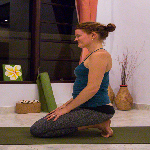

In [297]:
#sanity check look at an image and the corresponding label
array_to_img(train_images[12])

In [298]:
train_labels_final[:0]

array([], shape=(0, 32), dtype=float32)

In [299]:
# Now standardize the data standardize and/or center your dataset. 
# For images, a common thing that is done is to make sure each pixel value is between 0 and 1.
# This can be done by dividing the entire matrix by 255
train_img_final = train_img_unrow/255
test_img_final = test_img_unrow/255

type(test_img_unrow)

numpy.ndarray

In [27]:
y_train = keras.utils.to_categorical(train_img_unrow, 10)
y_test = keras.utils.to_categorical(test_img_unrow, 10) 


NameError: name 'train_img_unrow' is not defined

In [301]:
y_train[0]


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 

In [302]:
y_test[0]


array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 

In [42]:
yoga_test = test_datagen.flow_from_directory("DATASET/TEST",
        target_size=(150, 150),
        color_mode='rgba',                                     
        batch_size=32,
        class_mode='categorical',
        shuffle=False                                     
        )
                                            
                                            

Found 470 images belonging to 5 classes.


## Designing the Model

- Designing a CNN using Keras! Remember a few things when doing this:

- You should alternate convolutional and pooling layers
- You should have later layers have a larger number of parameters in order to detect more abstract patterns
- Add some final dense layers to add a classifier to the convolutional base
- Compile this model

In [48]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(150, 150, 4)), 
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
])


In [20]:
from tensorflow.keras import models, layers, optimizers, losses, metrics
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score 
from sklearn.dummy import DummyClassifier


In [59]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), metrics.AUC(name='prc', curve='PR')])




In [60]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 90000)             0         
                                                                 
 dense_4 (Dense)             (None, 150)               13500150  
                                                                 
 dense_5 (Dense)             (None, 5)                 755       
                                                                 
Total params: 13,500,905
Trainable params: 13,500,905
Non-trainable params: 0
_________________________________________________________________


## Training and Evaluating the Model


- Reminder training deep networks is resource intensive: depending on the size of the data, even a CNN with 3-4 successive convolutional and pooling layers is appropiate to take a hours to train on a high end laptops. Using several epochs and several layers (alternating between convolutional and pooling), our model took about 15-30 minutes to run on new Macbook air

- If you are concerned with runtime, you may want to set your model to run the training epochs overnight.IF you are setting up your model to run over night make sure your settings are on disable from sleeping. 

In [52]:
#trying to figure out if there is a mismatch 
yoga_md1 = model.fit(train_generator, epochs = 20, validation_data = validation_generator)



Epoch 1/20


2023-01-03 18:27:56.194747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 49.0471 - accuracy: 0.2032 - recall: 0.2032 - auc: 0.5161 - prc: 0.2042

2023-01-03 18:28:04.923853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 11s 354ms/step - loss: 49.0471 - accuracy: 0.2032 - recall: 0.2032 - auc: 0.5161 - prc: 0.2042 - val_loss: 7.1996 - val_accuracy: 0.1674 - val_recall: 0.1674 - val_auc: 0.5256 - val_prc: 0.2057
Epoch 2/20
28/28 [==============================] - 10s 349ms/step - loss: 6.4459 - accuracy: 0.2564 - recall: 0.2379 - auc: 0.5373 - prc: 0.2244 - val_loss: 3.3509 - val_accuracy: 0.2651 - val_recall: 0.2419 - val_auc: 0.5913 - val_prc: 0.2611
Epoch 3/20
28/28 [==============================] - 10s 362ms/step - loss: 3.0276 - accuracy: 0.3152 - recall: 0.2841 - auc: 0.6245 - prc: 0.2935 - val_loss: 2.5485 - val_accuracy: 0.4372 - val_recall: 0.4047 - val_auc: 0.7115 - val_prc: 0.4300
Epoch 4/20
28/28 [==============================] - 10s 359ms/step - loss: 3.3917 - accuracy: 0.3718 - recall: 0.3372 - auc: 0.6477 - prc: 0.3314 - val_loss: 3.9966 - val_accuracy: 0.3023 - val_recall: 0.3023 - val_auc: 0.5841 - val_prc: 0.3065
Epoch 5/20
28/28 [============

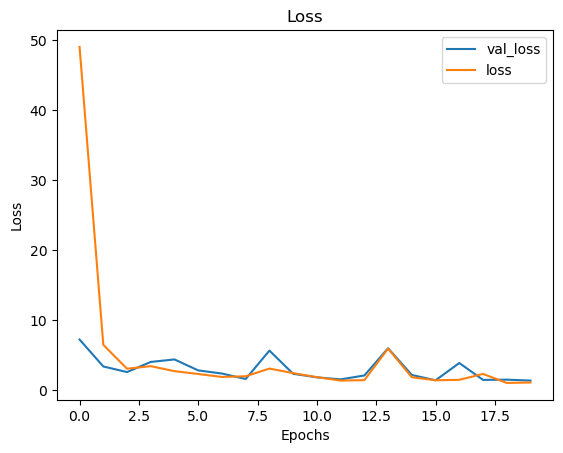

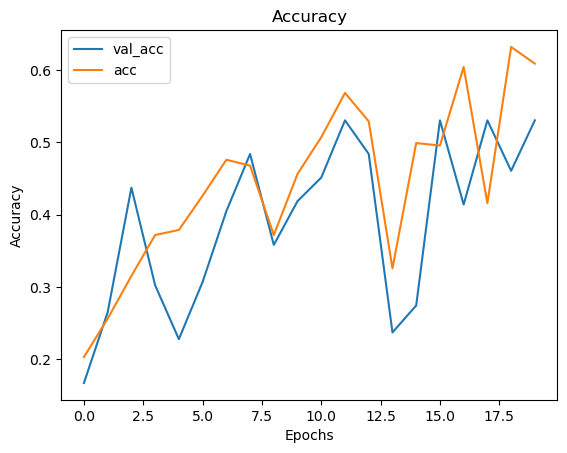

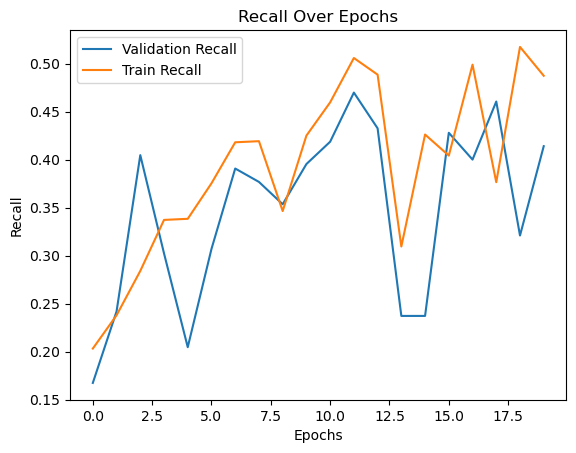

In [58]:
visualize_training_results(yoga_md1)


### After running yoga_md1 as a base model I will slowly add layers to increase my val_accuracy score ,I'll start by adding Conv2d ,then a dense layer.


# Convolutional Neural Network Models

### Running model 2 adding Conv2d, Max pooling 

In [161]:
# adding a few layers such as Conv2D,MaxPooling2,dropout,and leaving flatten to default settings
model2 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
])


In [162]:
optimizer = Adam(learning_rate=0.001)
model2.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), metrics.AUC(name='prc', curve='PR')])


model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 360000)            0         
                                                                 
 dropout_12 (Dropout)        (None, 360000)            0         
                                                                 
 dense_22 (Dense)            (None, 150)               54000150  
                                                                 
 dense_23 (Dense)            (None, 5)                 755       
                                                     

In [163]:
yoga_md2  = model2.fit(train_generator, epochs = 30, validation_data = validation_generator)


Epoch 1/30


2022-12-21 18:56:33.933940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 15.6617 - accuracy: 0.2321 - recall: 0.1328 - auc: 0.5245 - prc: 0.2205

2022-12-21 18:56:45.847666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 14s 443ms/step - loss: 15.6617 - accuracy: 0.2321 - recall: 0.1328 - auc: 0.5245 - prc: 0.2205 - val_loss: 1.5898 - val_accuracy: 0.3209 - val_recall: 0.0233 - val_auc: 0.6359 - val_prc: 0.3031
Epoch 2/30
28/28 [==============================] - 12s 412ms/step - loss: 1.4372 - accuracy: 0.4711 - recall: 0.0554 - auc: 0.7319 - prc: 0.4267 - val_loss: 1.3834 - val_accuracy: 0.4186 - val_recall: 0.0651 - val_auc: 0.7435 - val_prc: 0.4547
Epoch 3/30
28/28 [==============================] - 12s 423ms/step - loss: 1.1527 - accuracy: 0.5993 - recall: 0.2471 - auc: 0.8450 - prc: 0.6411 - val_loss: 1.3580 - val_accuracy: 0.4279 - val_recall: 0.1721 - val_auc: 0.7579 - val_prc: 0.4751
Epoch 4/30
28/28 [==============================] - 12s 420ms/step - loss: 0.8917 - accuracy: 0.6998 - recall: 0.4596 - auc: 0.9127 - prc: 0.7787 - val_loss: 1.2454 - val_accuracy: 0.5209 - val_recall: 0.3581 - val_auc: 0.8092 - val_prc: 0.5353
Epoch 5/30
28/28 [============

## Accuracy score improved from .57 TO .77 

In [157]:
model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 360000)            0         
                                                                 
 dropout_11 (Dropout)        (None, 360000)            0         
                                                                 
 dense_20 (Dense)            (None, 150)               54000150  
                                                                 
 dense_21 (Dense)            (None, 5)                 755       
                                                     

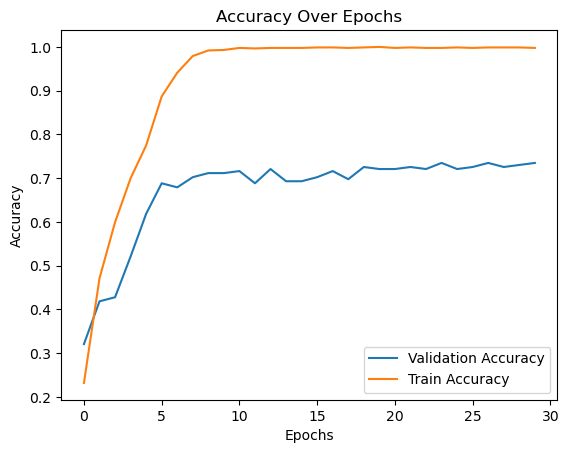

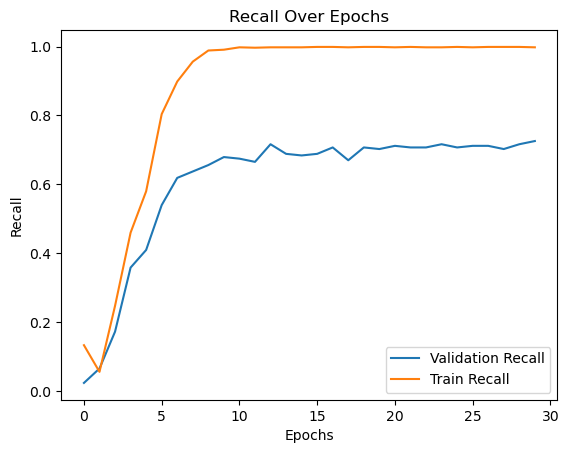

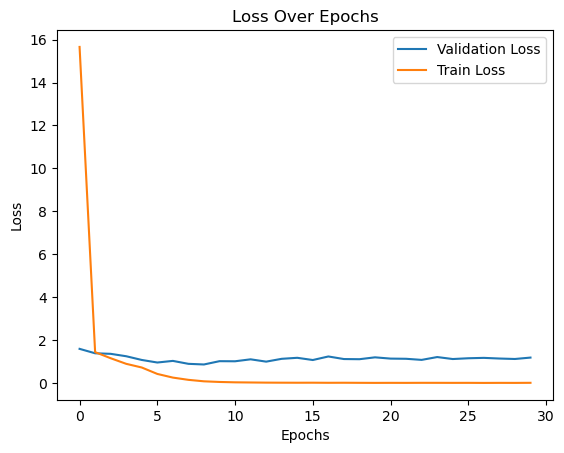

In [255]:
visualize_training_results(yoga_md2)


# Running model 3 
## still looking for improvement looking to add layers for better results


In [184]:
model3 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model3.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])
epochs = 50  
batch_size = 16

model3.summary()



Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 360000)            0         
                                                                 
 dropout_18 (Dropout)        (None, 360000)            0         
                                                                 
 dense_39 (Dense)            (None, 64)                23040064  
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                     

In [185]:
yoga_md3  = model3.fit(train_generator, epochs = 30, validation_data = validation_generator)


Epoch 1/30


2022-12-22 14:26:28.146091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 8.2767 - accuracy: 0.2148 - recall: 0.1097 - auc: 0.5322 - prc: 0.2137

2022-12-22 14:26:39.289039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 13s 445ms/step - loss: 8.2767 - accuracy: 0.2148 - recall: 0.1097 - auc: 0.5322 - prc: 0.2137 - val_loss: 1.5689 - val_accuracy: 0.3209 - val_recall: 0.0000e+00 - val_auc: 0.6321 - val_prc: 0.2794
Epoch 2/30
28/28 [==============================] - 12s 411ms/step - loss: 1.4576 - accuracy: 0.4400 - recall: 0.0254 - auc: 0.7320 - prc: 0.4079 - val_loss: 1.4161 - val_accuracy: 0.4419 - val_recall: 0.0465 - val_auc: 0.7343 - val_prc: 0.4273
Epoch 3/30
28/28 [==============================] - 12s 414ms/step - loss: 1.1822 - accuracy: 0.5797 - recall: 0.2240 - auc: 0.8340 - prc: 0.6168 - val_loss: 1.2319 - val_accuracy: 0.5488 - val_recall: 0.2093 - val_auc: 0.8110 - val_prc: 0.5694
Epoch 4/30
28/28 [==============================] - 12s 416ms/step - loss: 0.9130 - accuracy: 0.7055 - recall: 0.4307 - auc: 0.9094 - prc: 0.7676 - val_loss: 1.2093 - val_accuracy: 0.5628 - val_recall: 0.3256 - val_auc: 0.8298 - val_prc: 0.5855
Epoch 5/30
28/28 [=========

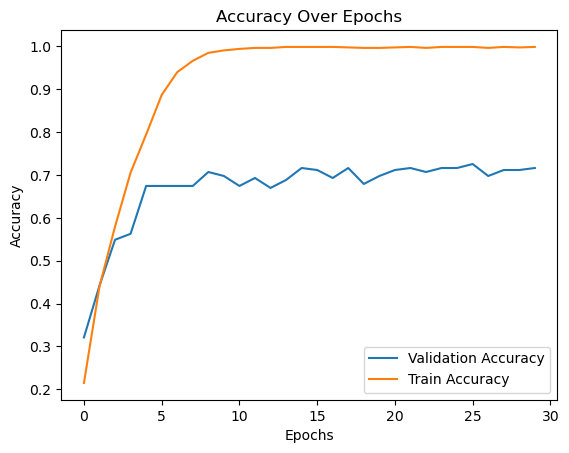

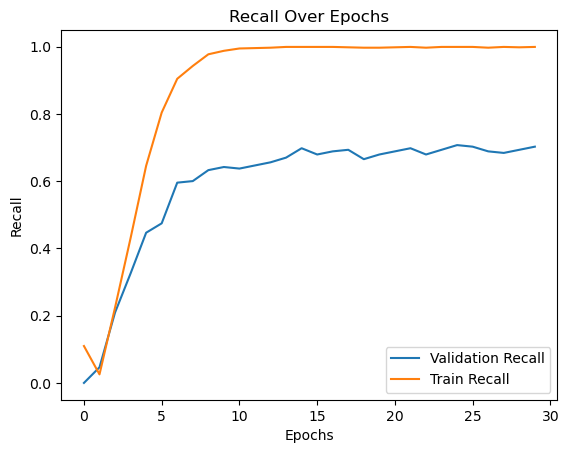

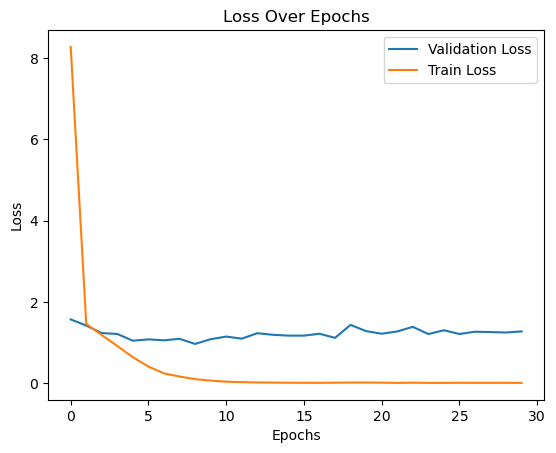

In [186]:

visualize_training_results(yoga_md3)

In [189]:

model4 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(5, activation='softmax')])

optimizer = Adam(learning_rate=0.001)
model4.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


model4.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 360000)            0         
                                                                 
 dropout_21 (Dropout)        (None, 360000)            0         
                                                                 
 dense_44 (Dense)            (None, 150)               54000150  
                                                                 
 dropout_22 (Dropout)        (None, 150)               0         
                                                     

In [191]:

yoga_md4  = model4.fit(train_generator, epochs = 30, validation_data = validation_generator)


Epoch 1/30


2022-12-22 14:41:29.550843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 11.4706 - accuracy: 0.2206 - recall: 0.0855 - auc: 0.5034 - prc: 0.2055

2022-12-22 14:41:41.558422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 14s 477ms/step - loss: 11.4706 - accuracy: 0.2206 - recall: 0.0855 - auc: 0.5034 - prc: 0.2055 - val_loss: 1.6047 - val_accuracy: 0.2326 - val_recall: 0.0000e+00 - val_auc: 0.5339 - val_prc: 0.2359
Epoch 2/30
28/28 [==============================] - 13s 441ms/step - loss: 1.5960 - accuracy: 0.2402 - recall: 0.0023 - auc: 0.5628 - prc: 0.2377 - val_loss: 1.5883 - val_accuracy: 0.2698 - val_recall: 0.0000e+00 - val_auc: 0.5914 - val_prc: 0.2652
Epoch 3/30
28/28 [==============================] - 12s 428ms/step - loss: 1.5481 - accuracy: 0.2956 - recall: 0.0219 - auc: 0.6269 - prc: 0.2977 - val_loss: 1.4686 - val_accuracy: 0.3581 - val_recall: 0.0279 - val_auc: 0.7080 - val_prc: 0.3782
Epoch 4/30
28/28 [==============================] - 12s 436ms/step - loss: 1.4393 - accuracy: 0.3788 - recall: 0.0878 - auc: 0.7092 - prc: 0.4079 - val_loss: 1.3843 - val_accuracy: 0.4651 - val_recall: 0.0837 - val_auc: 0.7747 - val_prc: 0.4926
Epoch 5/30
28/28 [====

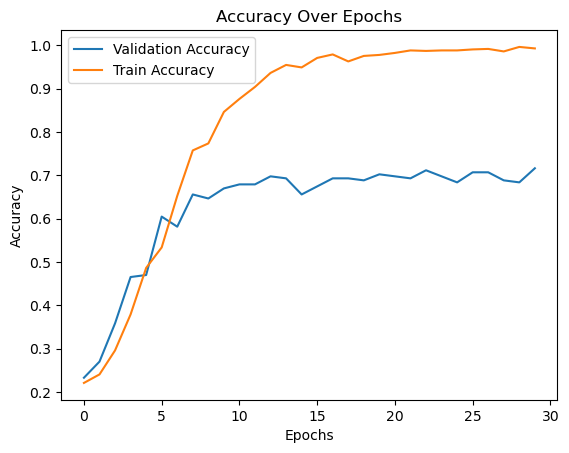

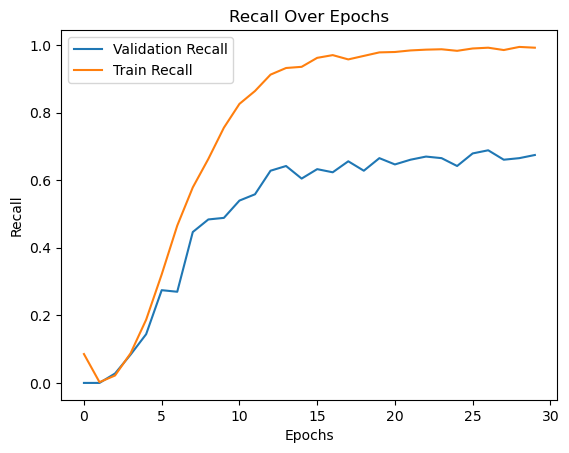

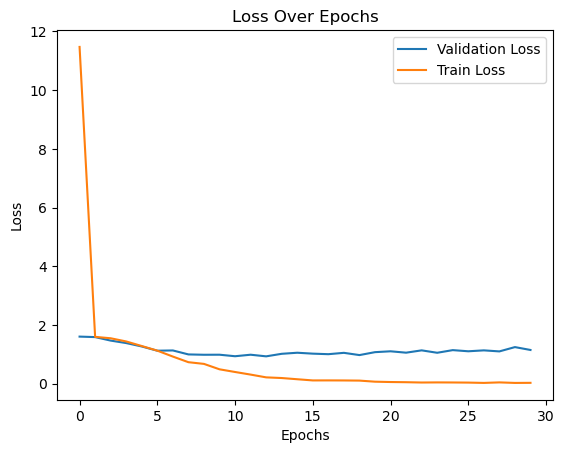

In [192]:
visualize_training_results(yoga_md4)

In [268]:
model5 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model5.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


model5.summary()



Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 flatten_35 (Flatten)        (None, 360000)            0         
                                                                 
 dropout_46 (Dropout)        (None, 360000)            0         
                                                                 
 dense_78 (Dense)            (None, 150)               54000150  
                                                                 
 dropout_47 (Dropout)        (None, 150)               0         
                                                     

In [269]:
model5_results = model5.fit(train_generator_aug, epochs = 40, validation_data = validation_generator_aug)

Epoch 1/40


2022-12-22 22:40:02.382653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 13.4499 - accuracy: 0.1952 - recall: 0.1016 - auc: 0.5032 - prc: 0.2005

2022-12-22 22:40:17.010606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 18s 584ms/step - loss: 13.4499 - accuracy: 0.1952 - recall: 0.1016 - auc: 0.5032 - prc: 0.2005 - val_loss: 1.6011 - val_accuracy: 0.2372 - val_recall: 0.0000e+00 - val_auc: 0.5710 - val_prc: 0.2374
Epoch 2/40
28/28 [==============================] - 15s 531ms/step - loss: 1.6186 - accuracy: 0.2402 - recall: 0.0035 - auc: 0.5291 - prc: 0.2191 - val_loss: 1.5993 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5756 - val_prc: 0.2265
Epoch 3/40
28/28 [==============================] - 16s 548ms/step - loss: 1.5985 - accuracy: 0.2413 - recall: 0.0023 - auc: 0.5836 - prc: 0.2479 - val_loss: 1.5947 - val_accuracy: 0.2512 - val_recall: 0.0000e+00 - val_auc: 0.5733 - val_prc: 0.2297
Epoch 4/40
28/28 [==============================] - 15s 508ms/step - loss: 1.5955 - accuracy: 0.2471 - recall: 0.0035 - auc: 0.5658 - prc: 0.2382 - val_loss: 1.5860 - val_accuracy: 0.2837 - val_recall: 0.0047 - val_auc: 0.5835 - val_prc: 0.2408
Epoch 5/40
28/28 [

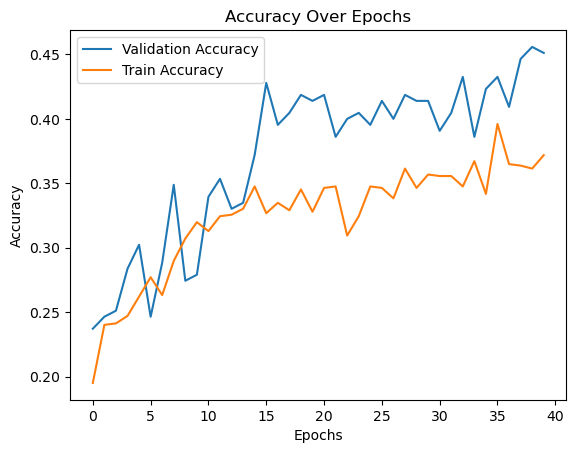

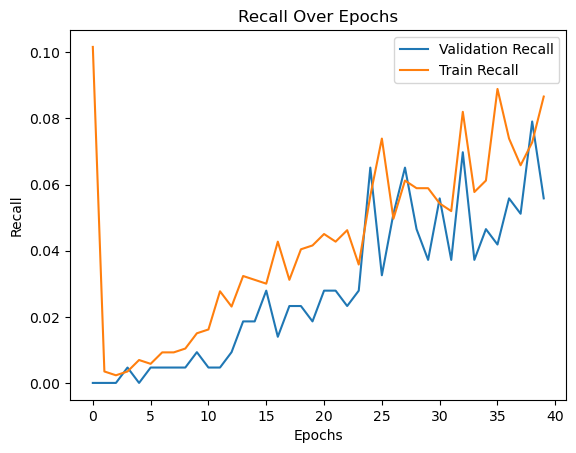

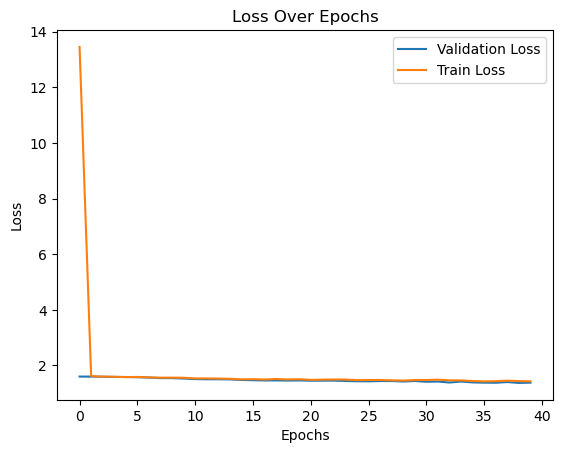

In [270]:
#add the 2 augmentation
#zoom_range=0.2, # zoom
#horizontal_flip=True,# horizontal flip
#added vertical_flip=True,

visualize_training_results(model5_results)


In [280]:
#taking out one of the dropout .50

model6 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64,(3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model6.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


model6.summary()



Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 flatten_36 (Flatten)        (None, 360000)            0         
                                                                 
 dense_80 (Dense)            (None, 150)               54000150  
                                                                 
 dropout_48 (Dropout)        (None, 150)               0         
                                                                 
 dense_81 (Dense)            (None, 5)                 755       
                                                     

In [281]:
# added vertical flip to model5 Architecture and increased the epochs to 40 added rotation
model6_results = model6.fit(train_generator_aug, epochs = 40, validation_data = validation_generator_aug)

Epoch 1/40


2022-12-22 23:10:47.689753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 12.7512 - accuracy: 0.2182 - recall: 0.1166 - auc: 0.5070 - prc: 0.2038

2022-12-22 23:11:00.403897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 15s 498ms/step - loss: 12.7512 - accuracy: 0.2182 - recall: 0.1166 - auc: 0.5070 - prc: 0.2038 - val_loss: 1.5755 - val_accuracy: 0.3116 - val_recall: 0.0047 - val_auc: 0.6440 - val_prc: 0.3113
Epoch 2/40
28/28 [==============================] - 14s 473ms/step - loss: 1.6156 - accuracy: 0.2818 - recall: 0.0035 - auc: 0.5778 - prc: 0.2523 - val_loss: 1.5653 - val_accuracy: 0.3907 - val_recall: 0.0000e+00 - val_auc: 0.7081 - val_prc: 0.3726
Epoch 3/40
28/28 [==============================] - 14s 482ms/step - loss: 1.5801 - accuracy: 0.2921 - recall: 0.0012 - auc: 0.6104 - prc: 0.2673 - val_loss: 1.5329 - val_accuracy: 0.3767 - val_recall: 0.0047 - val_auc: 0.6853 - val_prc: 0.3368
Epoch 4/40
28/28 [==============================] - 13s 469ms/step - loss: 1.5487 - accuracy: 0.3129 - recall: 0.0058 - auc: 0.6419 - prc: 0.2925 - val_loss: 1.5082 - val_accuracy: 0.3349 - val_recall: 0.0000e+00 - val_auc: 0.7052 - val_prc: 0.3284
Epoch 5/40
28/28 [====

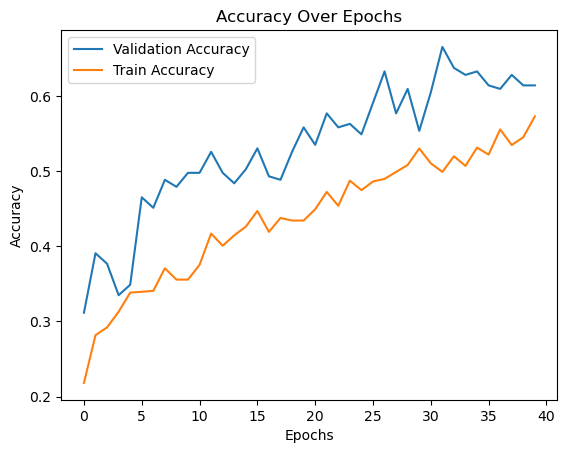

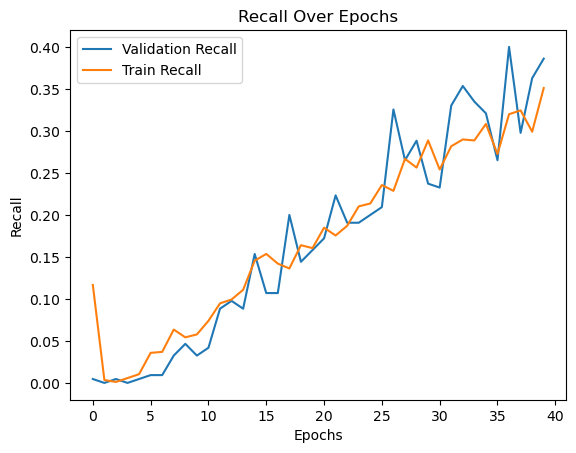

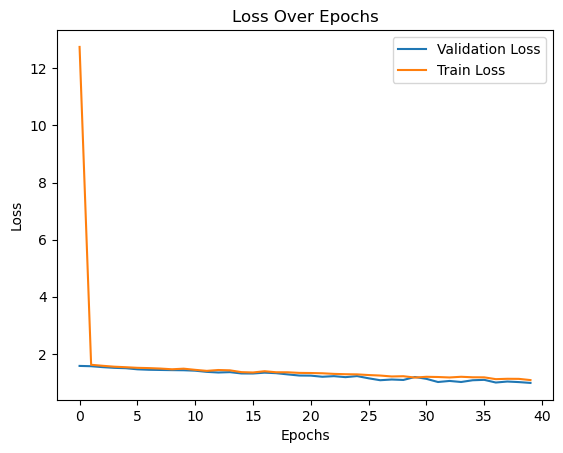

In [282]:
# model4
# add the 2 augmentation
# zoom_range=0.2, # zoom
# horizontal_flip=True,
# model5 added vertical flip I still need to train the moodel will add aditional augmentation
# added rotation_range=40 to model 6 
visualize_training_results(model6_results)

## Taking out the Dropout it seems like there is to much regularization so will run with out drop out layers, Reason was my validation acuracy was higher than training accuracy 

In [353]:
model7= tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding ='Same', input_shape=(150, 150, 4)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3,3), padding='Same', activation='relu'),#
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model7.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


model7.summary()



Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 75, 75, 32)        18464     
                                                                 
 flatten_49 (Flatten)        (None, 180000)            0         
                                                                 
 dense_106 (Dense)           (None, 150)               27000150  
                                                                 
 dense_107 (Dense)           (None, 5)                 755       
                                                     

In [ ]:
 """
        zoom_range=0.2, # zoom
        #width_shift_range=0.2,
        ##height_shift_range=0.0,
        #horizontal_flip=True,# horizontal flip
        #vertical_flip=True,
        #rotation_range=40,
        #shear_range=0.2,
        rescale=1./255, validation_split=0.20)
        
        how model7 was set up got rid of dropout and data seems to be doing better still has room for improvements 
"""

In [354]:
model7_results = model7.fit(train_generator_aug, epochs = 40, validation_data = validation_generator_aug)

Epoch 1/40


2022-12-23 13:54:59.640316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 2.8979 - accuracy: 0.2841 - recall: 0.0312 - auc: 0.5738 - prc: 0.2462

2022-12-23 13:55:11.752206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 15s 492ms/step - loss: 2.8979 - accuracy: 0.2841 - recall: 0.0312 - auc: 0.5738 - prc: 0.2462 - val_loss: 1.5407 - val_accuracy: 0.2977 - val_recall: 0.0047 - val_auc: 0.6444 - val_prc: 0.3279
Epoch 2/40
28/28 [==============================] - 13s 450ms/step - loss: 1.4751 - accuracy: 0.4076 - recall: 0.0624 - auc: 0.6910 - prc: 0.3762 - val_loss: 1.5142 - val_accuracy: 0.4326 - val_recall: 0.1116 - val_auc: 0.6572 - val_prc: 0.4232
Epoch 3/40
28/28 [==============================] - 13s 466ms/step - loss: 1.4024 - accuracy: 0.4249 - recall: 0.1386 - auc: 0.7382 - prc: 0.4448 - val_loss: 1.4176 - val_accuracy: 0.4047 - val_recall: 0.1070 - val_auc: 0.7348 - val_prc: 0.4295
Epoch 4/40
28/28 [==============================] - 13s 455ms/step - loss: 1.2750 - accuracy: 0.4815 - recall: 0.2390 - auc: 0.7855 - prc: 0.5305 - val_loss: 1.2988 - val_accuracy: 0.4884 - val_recall: 0.1860 - val_auc: 0.8020 - val_prc: 0.5230
Epoch 5/40
28/28 [=============

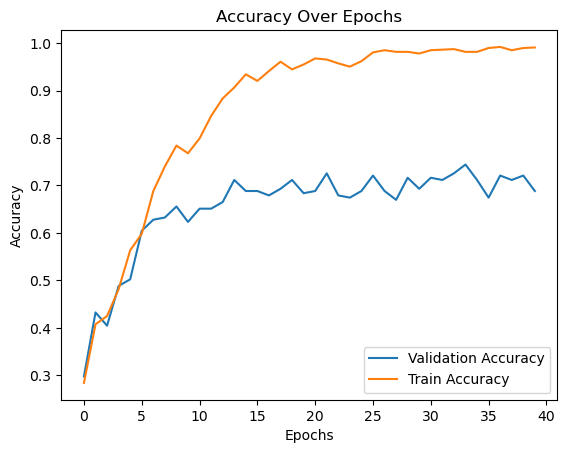

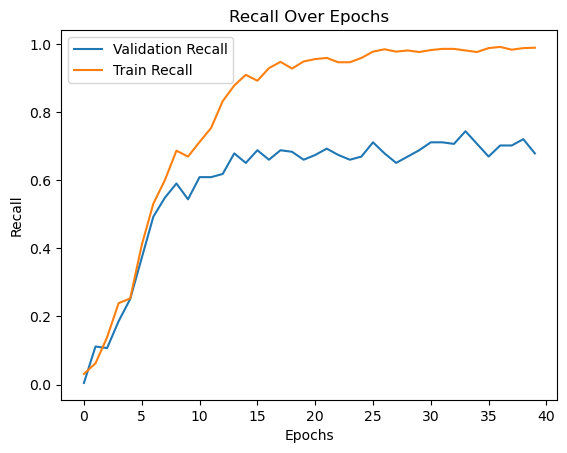

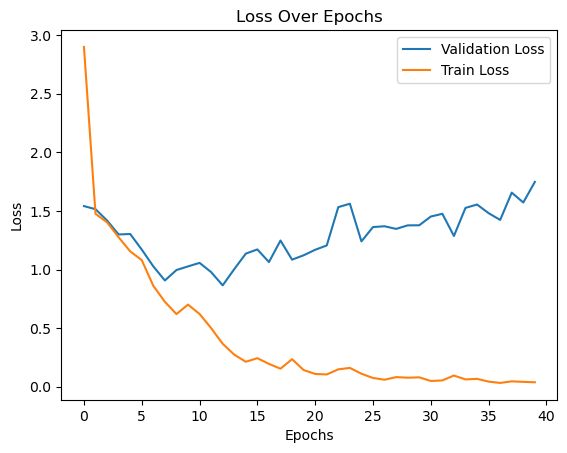

In [355]:
visualize_training_results(model7_results)

In [357]:
model8= tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding ='Same', input_shape=(150, 150, 4)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3,3), padding='Same', activation='relu'),#
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model8.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


model8.summary()



Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 75, 75, 32)        18464     
                                                                 
 flatten_50 (Flatten)        (None, 180000)            0         
                                                                 
 dense_108 (Dense)           (None, 150)               27000150  
                                                                 
 dense_109 (Dense)           (None, 5)                 755       
                                                     

In [358]:
# adding width_shift=.20
model8_results = model8.fit(train_generator_aug, epochs = 40, validation_data = validation_generator_aug)

Epoch 1/40


2022-12-23 14:14:55.265410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 3.3850 - accuracy: 0.2587 - recall: 0.0427 - auc: 0.5548 - prc: 0.2336

2022-12-23 14:15:07.621759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 15s 486ms/step - loss: 3.3850 - accuracy: 0.2587 - recall: 0.0427 - auc: 0.5548 - prc: 0.2336 - val_loss: 1.6046 - val_accuracy: 0.3116 - val_recall: 0.0140 - val_auc: 0.6048 - val_prc: 0.2835
Epoch 2/40
28/28 [==============================] - 13s 463ms/step - loss: 1.5780 - accuracy: 0.2540 - recall: 0.0115 - auc: 0.5919 - prc: 0.2635 - val_loss: 1.5446 - val_accuracy: 0.3163 - val_recall: 0.0093 - val_auc: 0.6350 - val_prc: 0.2995
Epoch 3/40
28/28 [==============================] - 13s 462ms/step - loss: 1.5669 - accuracy: 0.3025 - recall: 0.0139 - auc: 0.6239 - prc: 0.2840 - val_loss: 1.5119 - val_accuracy: 0.2744 - val_recall: 0.0186 - val_auc: 0.6490 - val_prc: 0.3234
Epoch 4/40
28/28 [==============================] - 13s 456ms/step - loss: 1.5230 - accuracy: 0.3279 - recall: 0.0577 - auc: 0.6663 - prc: 0.3314 - val_loss: 1.4820 - val_accuracy: 0.3860 - val_recall: 0.0093 - val_auc: 0.7156 - val_prc: 0.4210
Epoch 5/40
28/28 [=============

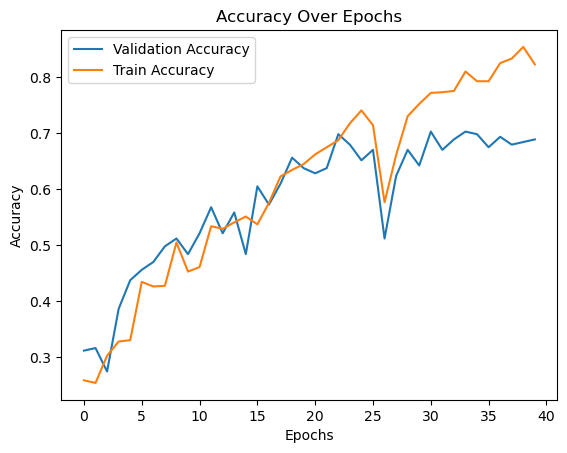

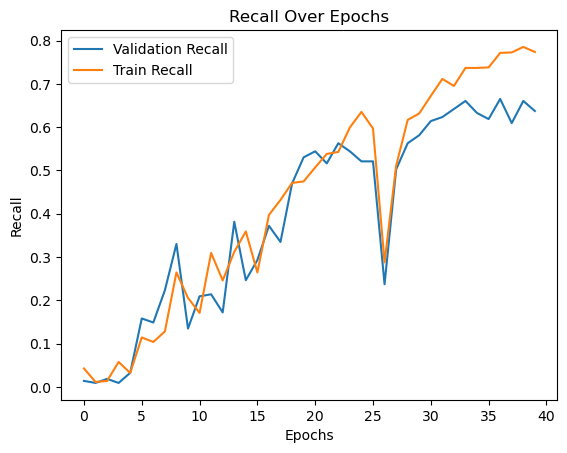

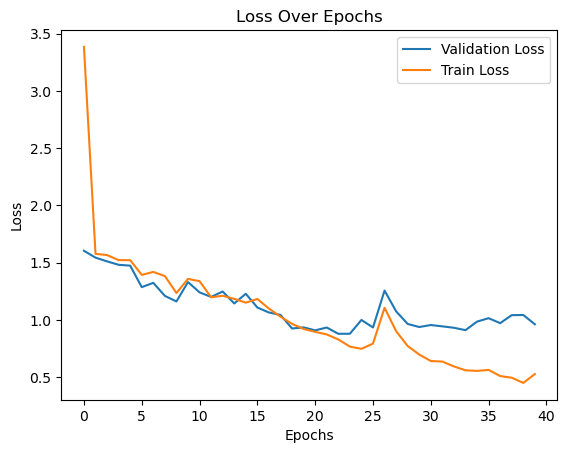

In [359]:
visualize_training_results(model8_results)

In [ ]:
"""
So realizing the dropout has worked training data still has nore training to go, with out over fitting now 
I'll adjust more augmentation to my data and see if we can get
a bit higher validation score Id like to get at or above .85

"""

# Re-Running model 8

In [394]:
mod_8= tf.keras.models.Sequential([
       tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
       tf.keras.layers.MaxPooling2D(2, 2),
       tf.keras.layers.Conv2D(32, 3, padding='Same', activation='relu'),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(150, activation='relu'),
       tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
mod_8.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


mod_8.summary()

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_85 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_86 (Conv2D)          (None, 75, 75, 32)        18464     
                                                                 
 flatten_57 (Flatten)        (None, 180000)            0         
                                                                 
 dense_122 (Dense)           (None, 150)               27000150  
                                                                 
 dense_123 (Dense)           (None, 5)                 755       
                                                     

In [395]:
mod_8_results = mod_8.fit(train_generator_aug, epochs = 100, validation_data = validation_generator_aug)

Epoch 1/100


2022-12-23 19:08:30.535820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 3.8116 - accuracy: 0.2102 - recall: 0.0393 - auc: 0.5037 - prc: 0.2062

2022-12-23 19:08:43.402566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 22s 491ms/step - loss: 3.8116 - accuracy: 0.2102 - recall: 0.0393 - auc: 0.5037 - prc: 0.2062 - val_loss: 1.6079 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5509 - val_prc: 0.2270
Epoch 2/100
28/28 [==============================] - 13s 460ms/step - loss: 1.6047 - accuracy: 0.2298 - recall: 0.0035 - auc: 0.5654 - prc: 0.2386 - val_loss: 1.6049 - val_accuracy: 0.2837 - val_recall: 0.0000e+00 - val_auc: 0.5720 - val_prc: 0.2424
Epoch 3/100
28/28 [==============================] - 13s 472ms/step - loss: 1.5975 - accuracy: 0.2506 - recall: 0.0035 - auc: 0.5553 - prc: 0.2328 - val_loss: 1.5918 - val_accuracy: 0.2419 - val_recall: 0.0000e+00 - val_auc: 0.5897 - val_prc: 0.2708
Epoch 4/100
28/28 [==============================] - 13s 458ms/step - loss: 1.6330 - accuracy: 0.2494 - recall: 0.0092 - auc: 0.5590 - prc: 0.2321 - val_loss: 1.5970 - val_accuracy: 0.2372 - val_recall: 0.0000e+00 - val_auc: 0.5715 - val_prc: 0.2439
Epoch 5/100


28/28 [==============================] - 14s 504ms/step - loss: 0.3224 - accuracy: 0.8926 - recall: 0.8580 - auc: 0.9862 - prc: 0.9556 - val_loss: 0.9953 - val_accuracy: 0.7116 - val_recall: 0.6930 - val_auc: 0.9105 - val_prc: 0.7684
Epoch 68/100
28/28 [==============================] - 14s 490ms/step - loss: 0.3015 - accuracy: 0.9018 - recall: 0.8730 - auc: 0.9875 - prc: 0.9626 - val_loss: 1.1380 - val_accuracy: 0.7070 - val_recall: 0.6884 - val_auc: 0.9087 - val_prc: 0.7684
Epoch 69/100
28/28 [==============================] - 14s 479ms/step - loss: 0.2711 - accuracy: 0.9249 - recall: 0.8926 - auc: 0.9898 - prc: 0.9706 - val_loss: 1.0116 - val_accuracy: 0.7349 - val_recall: 0.7163 - val_auc: 0.9153 - val_prc: 0.7873
Epoch 70/100
28/28 [==============================] - 14s 483ms/step - loss: 0.2768 - accuracy: 0.9065 - recall: 0.8799 - auc: 0.9903 - prc: 0.9697 - val_loss: 1.0413 - val_accuracy: 0.7116 - val_recall: 0.7070 - val_auc: 0.9111 - val_prc: 0.7737
Epoch 71/100
28/28 [=====

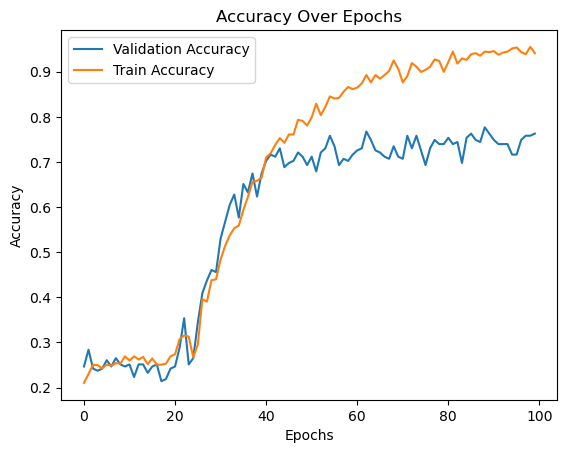

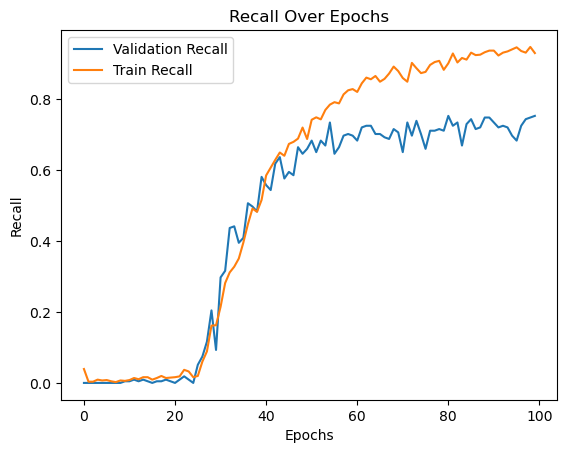

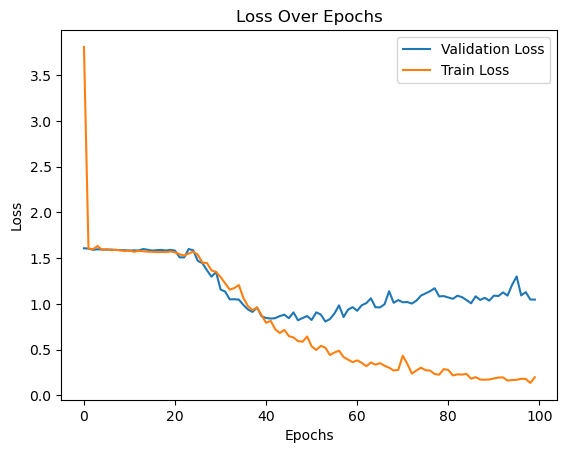

In [396]:
visualize_training_results(mod_8_results)

In [401]:
mod_8_A= tf.keras.models.Sequential([
       tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
       tf.keras.layers.MaxPooling2D(2, 2),
       tf.keras.layers.Conv2D(32, 3, padding='Same', activation='relu'),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(150, activation='relu'),
       tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
mod_8_A.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


mod_8_A.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_87 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_88 (Conv2D)          (None, 75, 75, 32)        18464     
                                                                 
 flatten_58 (Flatten)        (None, 180000)            0         
                                                                 
 dense_124 (Dense)           (None, 150)               27000150  
                                                                 
 dense_125 (Dense)           (None, 5)                 755       
                                                     

In [ ]:
running this model added 100 epochs and added data augmentation

In [402]:
mod_8_A_results = mod_8_A.fit(train_generator_aug, epochs = 100, validation_data = validation_generator_aug)

Epoch 1/100


2022-12-23 19:53:01.472036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 4.1030 - accuracy: 0.2263 - recall: 0.0150 - auc: 0.5029 - prc: 0.1986

2022-12-23 19:53:14.761276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 16s 496ms/step - loss: 4.1030 - accuracy: 0.2263 - recall: 0.0150 - auc: 0.5029 - prc: 0.1986 - val_loss: 1.6073 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5333 - val_prc: 0.2246
Epoch 2/100
28/28 [==============================] - 13s 460ms/step - loss: 1.6061 - accuracy: 0.2460 - recall: 0.0000e+00 - auc: 0.5550 - prc: 0.2291 - val_loss: 1.6042 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5653 - val_prc: 0.2336
Epoch 3/100
28/28 [==============================] - 13s 455ms/step - loss: 1.6036 - accuracy: 0.2460 - recall: 0.0000e+00 - auc: 0.5630 - prc: 0.2377 - val_loss: 1.6022 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5605 - val_prc: 0.2308
Epoch 4/100
28/28 [==============================] - 13s 455ms/step - loss: 1.6037 - accuracy: 0.2436 - recall: 0.0000e+00 - auc: 0.5641 - prc: 0.2314 - val_loss: 1.5919 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5665 - val_prc: 0.2384


Epoch 34/100
28/28 [==============================] - 14s 489ms/step - loss: 1.5654 - accuracy: 0.2875 - recall: 0.0173 - auc: 0.5963 - prc: 0.2756 - val_loss: 1.5913 - val_accuracy: 0.2326 - val_recall: 0.0140 - val_auc: 0.5675 - val_prc: 0.2419
Epoch 35/100
28/28 [==============================] - 14s 479ms/step - loss: 1.5630 - accuracy: 0.2667 - recall: 0.0173 - auc: 0.6006 - prc: 0.2753 - val_loss: 1.5950 - val_accuracy: 0.2651 - val_recall: 0.0186 - val_auc: 0.5658 - val_prc: 0.2396
Epoch 36/100
28/28 [==============================] - 13s 471ms/step - loss: 1.5595 - accuracy: 0.2633 - recall: 0.0139 - auc: 0.5959 - prc: 0.2760 - val_loss: 1.5912 - val_accuracy: 0.2605 - val_recall: 0.0140 - val_auc: 0.5664 - val_prc: 0.2407
Epoch 37/100
28/28 [==============================] - 14s 475ms/step - loss: 1.5565 - accuracy: 0.2725 - recall: 0.0231 - auc: 0.5943 - prc: 0.2785 - val_loss: 1.5718 - val_accuracy: 0.2698 - val_recall: 0.0140 - val_auc: 0.5896 - val_prc: 0.2568
Epoch 38/100

28/28 [==============================] - 14s 494ms/step - loss: 1.5029 - accuracy: 0.3095 - recall: 0.0242 - auc: 0.6431 - prc: 0.3268 - val_loss: 1.5767 - val_accuracy: 0.2605 - val_recall: 0.0140 - val_auc: 0.5970 - val_prc: 0.2778


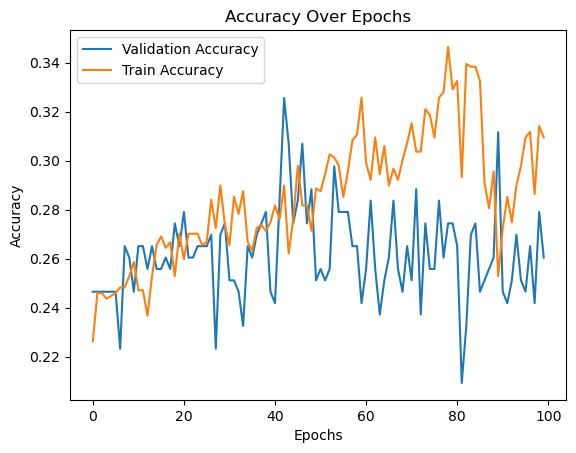

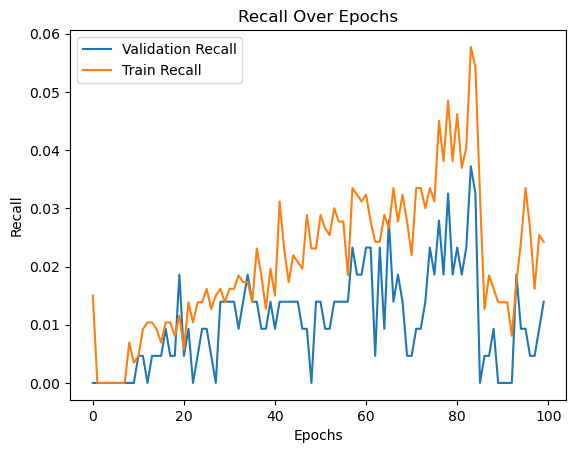

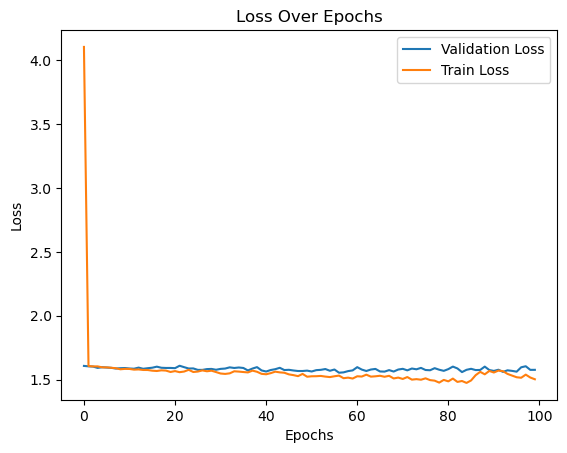

In [403]:
visualize_training_results(mod_8_A_results)

In [ ]:
  #added 100 epochs and added width shift 
    #* zoom_range=0.2, # zoom
    #* width_shift_range=0.2,
       # height_shift_range=0.2,
       # horizontal_flip=True,# horizontal flip
       # vertical_flip=True,

In [404]:
mod_8_B= tf.keras.models.Sequential([
       tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
       tf.keras.layers.MaxPooling2D(2, 2),
       tf.keras.layers.Conv2D(32, 3, padding='Same', activation='relu'),
       tf.keras.layers.MaxPooling2D(2, 2),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(150, activation='relu'),
       tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
mod_8_B.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


mod_8_B.summary()

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_89 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_90 (Conv2D)          (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 flatten_59 (Flatten)        (None, 43808)             0         
                                                                 
 dense_126 (Dense)           (None, 150)             

In [405]:
mod_8_B_results = mod_8_B.fit(train_generator_aug, epochs = 100, validation_data = validation_generator_aug)

Epoch 1/100


2022-12-23 20:17:01.613188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 2.0434 - accuracy: 0.2171 - recall: 0.0173 - auc: 0.5254 - prc: 0.2092

2022-12-23 20:17:13.882044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 15s 478ms/step - loss: 2.0434 - accuracy: 0.2171 - recall: 0.0173 - auc: 0.5254 - prc: 0.2092 - val_loss: 1.6074 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5531 - val_prc: 0.2222
Epoch 2/100
28/28 [==============================] - 13s 459ms/step - loss: 1.6037 - accuracy: 0.2379 - recall: 0.0000e+00 - auc: 0.5581 - prc: 0.2326 - val_loss: 1.6018 - val_accuracy: 0.2419 - val_recall: 0.0000e+00 - val_auc: 0.5730 - val_prc: 0.2420
Epoch 3/100
28/28 [==============================] - 12s 441ms/step - loss: 1.5954 - accuracy: 0.2448 - recall: 0.0035 - auc: 0.5703 - prc: 0.2367 - val_loss: 1.5902 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5736 - val_prc: 0.2409
Epoch 4/100
28/28 [==============================] - 13s 451ms/step - loss: 1.5890 - accuracy: 0.2517 - recall: 0.0023 - auc: 0.5717 - prc: 0.2422 - val_loss: 1.5809 - val_accuracy: 0.2605 - val_recall: 0.0047 - val_auc: 0.5960 - val_prc: 0.2718
Epoch 5/100


28/28 [==============================] - 13s 457ms/step - loss: 0.8980 - accuracy: 0.6651 - recall: 0.5231 - auc: 0.8982 - prc: 0.7480 - val_loss: 0.9351 - val_accuracy: 0.6698 - val_recall: 0.5535 - val_auc: 0.8882 - val_prc: 0.7405
Epoch 68/100
28/28 [==============================] - 13s 455ms/step - loss: 0.9141 - accuracy: 0.6455 - recall: 0.5104 - auc: 0.8944 - prc: 0.7375 - val_loss: 0.8890 - val_accuracy: 0.6744 - val_recall: 0.5256 - val_auc: 0.8974 - val_prc: 0.7662
Epoch 69/100
28/28 [==============================] - 13s 454ms/step - loss: 0.8571 - accuracy: 0.6767 - recall: 0.5266 - auc: 0.9088 - prc: 0.7671 - val_loss: 0.8686 - val_accuracy: 0.6605 - val_recall: 0.5442 - val_auc: 0.9021 - val_prc: 0.7672
Epoch 70/100
28/28 [==============================] - 13s 461ms/step - loss: 0.8903 - accuracy: 0.6697 - recall: 0.5254 - auc: 0.8989 - prc: 0.7483 - val_loss: 0.9311 - val_accuracy: 0.6419 - val_recall: 0.5256 - val_auc: 0.8870 - val_prc: 0.7323
Epoch 71/100
28/28 [=====

In [ ]:
#added 100 epochs and added height shift 
    #* zoom_range=0.2, # zoom
    #* width_shift_range=0.2,
    #* height_shift_range=0.2,
       # horizontal_flip=True,# horizontal flip
       # vertical_flip=True,

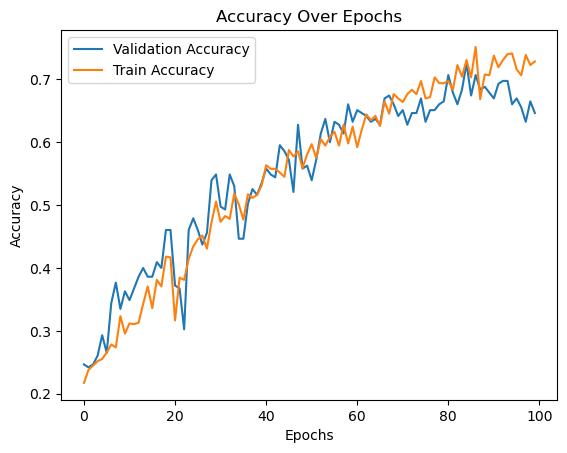

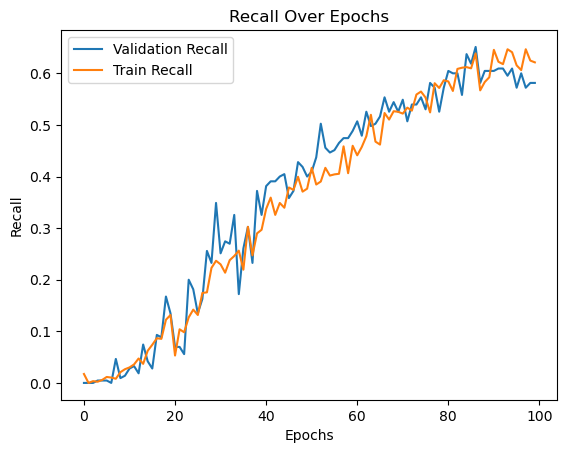

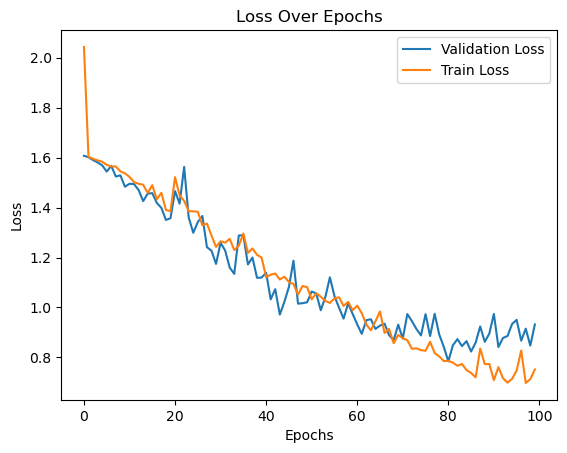

In [406]:
visualize_training_results(mod_8_B_results)

In [407]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 2:46:40.094792


In [409]:
mod_8_C= tf.keras.models.Sequential([
       tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
       tf.keras.layers.MaxPooling2D(2, 2),
       tf.keras.layers.Conv2D(32, 3, padding='Same', activation='relu'),
       tf.keras.layers.MaxPooling2D(2, 2),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(150, activation='relu'),
       tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
mod_8_C.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


mod_8_C.summary()

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_92 (Conv2D)          (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 flatten_60 (Flatten)        (None, 43808)             0         
                                                                 
 dense_128 (Dense)           (None, 150)             

In [410]:
mod_8_C_results = mod_8_C.fit(train_generator_aug, epochs = 150, validation_data = validation_generator_aug)

Epoch 1/150


2022-12-24 02:29:18.177294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 1.6739 - accuracy: 0.2587 - recall: 0.0150 - auc: 0.5645 - prc: 0.2347

2022-12-24 02:29:31.377087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 16s 506ms/step - loss: 1.6739 - accuracy: 0.2587 - recall: 0.0150 - auc: 0.5645 - prc: 0.2347 - val_loss: 1.5644 - val_accuracy: 0.3163 - val_recall: 0.0047 - val_auc: 0.6118 - val_prc: 0.2750
Epoch 2/150
28/28 [==============================] - 13s 450ms/step - loss: 1.5870 - accuracy: 0.2633 - recall: 0.0023 - auc: 0.5776 - prc: 0.2477 - val_loss: 1.5044 - val_accuracy: 0.3860 - val_recall: 0.0000e+00 - val_auc: 0.6695 - val_prc: 0.3474
Epoch 3/150
28/28 [==============================] - 13s 452ms/step - loss: 1.5577 - accuracy: 0.2829 - recall: 0.0058 - auc: 0.6171 - prc: 0.2741 - val_loss: 1.5077 - val_accuracy: 0.3395 - val_recall: 0.0047 - val_auc: 0.6738 - val_prc: 0.3457
Epoch 4/150
28/28 [==============================] - 12s 436ms/step - loss: 1.5880 - accuracy: 0.2691 - recall: 0.0115 - auc: 0.6104 - prc: 0.2701 - val_loss: 1.4834 - val_accuracy: 0.3814 - val_recall: 0.0093 - val_auc: 0.7146 - val_prc: 0.4016
Epoch 5/150
28/28 [=====

28/28 [==============================] - 13s 450ms/step - loss: 0.8961 - accuracy: 0.6582 - recall: 0.5335 - auc: 0.8999 - prc: 0.7449 - val_loss: 0.9844 - val_accuracy: 0.6558 - val_recall: 0.5628 - val_auc: 0.8905 - val_prc: 0.7329
Epoch 68/150
28/28 [==============================] - 13s 451ms/step - loss: 0.9301 - accuracy: 0.6432 - recall: 0.5092 - auc: 0.8944 - prc: 0.7320 - val_loss: 0.7814 - val_accuracy: 0.6791 - val_recall: 0.5581 - val_auc: 0.9210 - val_prc: 0.7899
Epoch 69/150
28/28 [==============================] - 12s 443ms/step - loss: 0.8576 - accuracy: 0.6859 - recall: 0.5346 - auc: 0.9097 - prc: 0.7721 - val_loss: 0.8361 - val_accuracy: 0.6977 - val_recall: 0.5721 - val_auc: 0.9108 - val_prc: 0.7689
Epoch 70/150
28/28 [==============================] - 13s 442ms/step - loss: 0.9553 - accuracy: 0.6374 - recall: 0.4885 - auc: 0.8867 - prc: 0.7108 - val_loss: 0.8694 - val_accuracy: 0.6512 - val_recall: 0.5349 - val_auc: 0.9085 - val_prc: 0.7688
Epoch 71/150
28/28 [=====

28/28 [==============================] - 13s 447ms/step - loss: 0.6612 - accuracy: 0.7436 - recall: 0.6674 - auc: 0.9448 - prc: 0.8474 - val_loss: 0.7980 - val_accuracy: 0.7163 - val_recall: 0.6512 - val_auc: 0.9235 - val_prc: 0.8131
Epoch 134/150
28/28 [==============================] - 13s 450ms/step - loss: 0.6071 - accuracy: 0.7818 - recall: 0.7067 - auc: 0.9536 - prc: 0.8694 - val_loss: 0.8120 - val_accuracy: 0.7442 - val_recall: 0.7023 - val_auc: 0.9288 - val_prc: 0.8261
Epoch 135/150
28/28 [==============================] - 13s 452ms/step - loss: 0.5900 - accuracy: 0.7910 - recall: 0.7125 - auc: 0.9560 - prc: 0.8766 - val_loss: 0.8537 - val_accuracy: 0.7209 - val_recall: 0.6465 - val_auc: 0.9182 - val_prc: 0.8039
Epoch 136/150
28/28 [==============================] - 13s 442ms/step - loss: 0.5993 - accuracy: 0.7829 - recall: 0.7229 - auc: 0.9547 - prc: 0.8743 - val_loss: 0.8846 - val_accuracy: 0.7023 - val_recall: 0.6837 - val_auc: 0.9212 - val_prc: 0.8057
Epoch 137/150
28/28 [=

In [424]:
#added 150 epochs and added horizontal_flip=True
    #* zoom_range=0.2, # zoom
    #* width_shift_range=0.2,
    #* height_shift_range=0.2,
    #* horizontal_flip=True,# horizontal flip
       # vertical_flip=True,

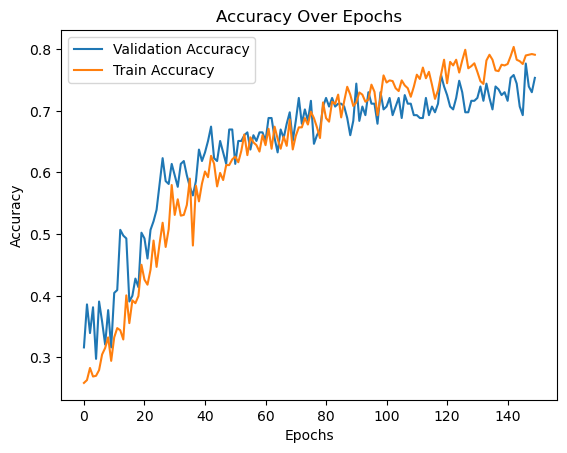

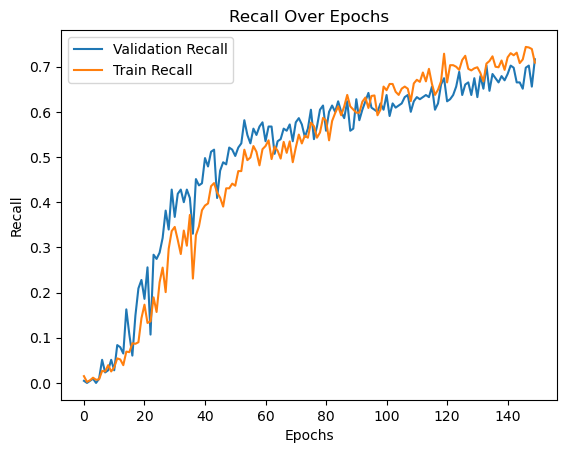

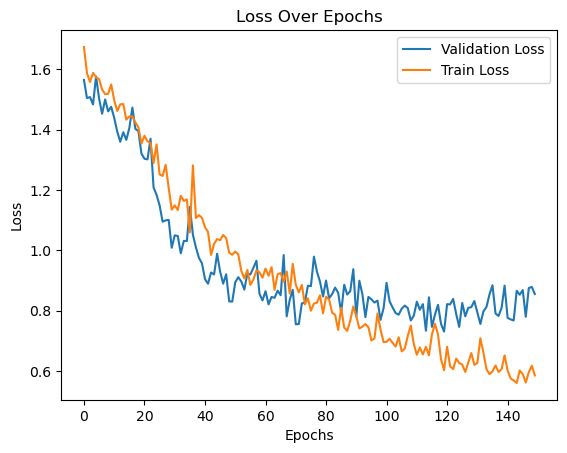

In [411]:
visualize_training_results(mod_8_C_results)

# adding vertical flip to model8_d

In [418]:
mod_8_D= tf.keras.models.Sequential([
       tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
       tf.keras.layers.MaxPooling2D(2, 2),
       tf.keras.layers.Conv2D(32, 3, padding='Same', activation='relu'),
       tf.keras.layers.MaxPooling2D(2, 2),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(150, activation='relu'),
       tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
mod_8_D.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


mod_8_D.summary()

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_95 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 flatten_62 (Flatten)        (None, 43808)             0         
                                                                 
 dense_132 (Dense)           (None, 150)             

In [419]:
mod_8_D_results = mod_8_D.fit(train_generator_aug, epochs = 150, validation_data = validation_generator_aug)

Epoch 1/150


2022-12-24 10:16:11.889704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 1.8000 - accuracy: 0.2540 - recall: 0.0150 - auc: 0.5264 - prc: 0.2120

2022-12-24 10:16:24.038888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 15s 465ms/step - loss: 1.8000 - accuracy: 0.2540 - recall: 0.0150 - auc: 0.5264 - prc: 0.2120 - val_loss: 1.6040 - val_accuracy: 0.2605 - val_recall: 0.0000e+00 - val_auc: 0.5289 - val_prc: 0.2304
Epoch 2/150
28/28 [==============================] - 13s 450ms/step - loss: 1.6071 - accuracy: 0.2436 - recall: 0.0000e+00 - auc: 0.5608 - prc: 0.2281 - val_loss: 1.6044 - val_accuracy: 0.2326 - val_recall: 0.0000e+00 - val_auc: 0.5313 - val_prc: 0.2095
Epoch 3/150
28/28 [==============================] - 12s 437ms/step - loss: 1.5957 - accuracy: 0.2229 - recall: 0.0000e+00 - auc: 0.5581 - prc: 0.2231 - val_loss: 1.5902 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5673 - val_prc: 0.2310
Epoch 4/150
28/28 [==============================] - 12s 443ms/step - loss: 1.5912 - accuracy: 0.2436 - recall: 0.0000e+00 - auc: 0.5665 - prc: 0.2337 - val_loss: 1.6122 - val_accuracy: 0.2837 - val_recall: 0.0000e+00 - val_auc: 0.5676 - val_prc: 0.2269


Epoch 34/150
28/28 [==============================] - 13s 431ms/step - loss: 1.5676 - accuracy: 0.2748 - recall: 0.0127 - auc: 0.5860 - prc: 0.2661 - val_loss: 1.5864 - val_accuracy: 0.2558 - val_recall: 0.0047 - val_auc: 0.5663 - val_prc: 0.2384
Epoch 35/150
28/28 [==============================] - 13s 447ms/step - loss: 1.5821 - accuracy: 0.2633 - recall: 0.0069 - auc: 0.5807 - prc: 0.2510 - val_loss: 1.5846 - val_accuracy: 0.2558 - val_recall: 0.0047 - val_auc: 0.5690 - val_prc: 0.2496
Epoch 36/150
28/28 [==============================] - 12s 438ms/step - loss: 1.5779 - accuracy: 0.2714 - recall: 0.0081 - auc: 0.5792 - prc: 0.2591 - val_loss: 1.6054 - val_accuracy: 0.2698 - val_recall: 0.0047 - val_auc: 0.5597 - val_prc: 0.2522
Epoch 37/150
28/28 [==============================] - 13s 448ms/step - loss: 1.5794 - accuracy: 0.2633 - recall: 0.0115 - auc: 0.5776 - prc: 0.2609 - val_loss: 1.5877 - val_accuracy: 0.2558 - val_recall: 0.0000e+00 - val_auc: 0.5745 - val_prc: 0.2410
Epoch 38

28/28 [==============================] - 13s 440ms/step - loss: 1.5140 - accuracy: 0.3268 - recall: 0.0335 - auc: 0.6549 - prc: 0.3241 - val_loss: 1.5329 - val_accuracy: 0.3209 - val_recall: 0.0465 - val_auc: 0.6641 - val_prc: 0.3365
Epoch 101/150
28/28 [==============================] - 13s 447ms/step - loss: 1.5010 - accuracy: 0.3303 - recall: 0.0508 - auc: 0.6562 - prc: 0.3339 - val_loss: 1.5365 - val_accuracy: 0.3023 - val_recall: 0.0326 - val_auc: 0.6438 - val_prc: 0.3074
Epoch 102/150
28/28 [==============================] - 13s 438ms/step - loss: 1.5015 - accuracy: 0.3326 - recall: 0.0416 - auc: 0.6608 - prc: 0.3439 - val_loss: 1.5363 - val_accuracy: 0.3163 - val_recall: 0.0186 - val_auc: 0.6490 - val_prc: 0.3051
Epoch 103/150
28/28 [==============================] - 13s 441ms/step - loss: 1.4989 - accuracy: 0.3314 - recall: 0.0346 - auc: 0.6615 - prc: 0.3357 - val_loss: 1.5163 - val_accuracy: 0.3488 - val_recall: 0.0326 - val_auc: 0.6551 - val_prc: 0.3316
Epoch 104/150
28/28 [=

In [425]:
#added 150 epochs and added vertical_flip=True
    #* zoom_range=0.2, # zoom
    #* width_shift_range=0.2,
    #* height_shift_range=0.2,
    #* horizontal_flip=True,# horizontal flip
    #* vertical_flip=True,

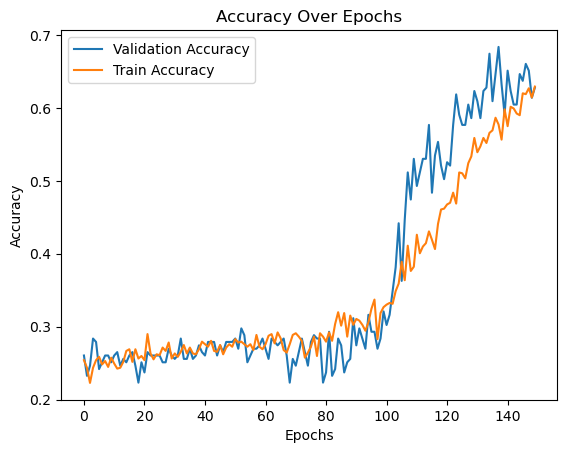

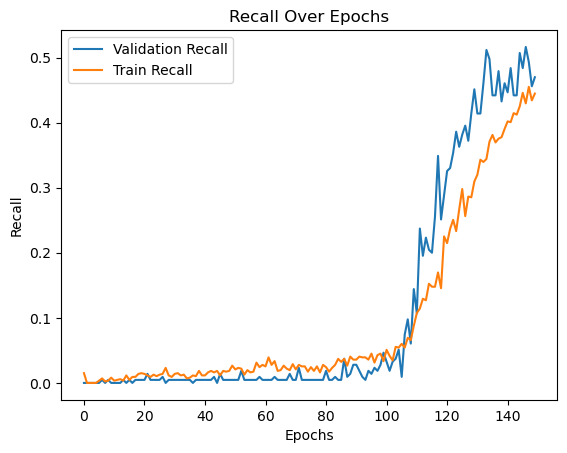

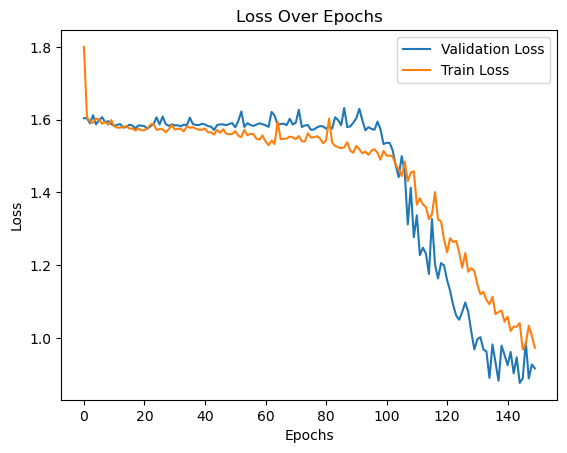

In [420]:
visualize_training_results(mod_8_D_results

In [421]:
mod_8_D_results = mod_8_D.fit(train_generator_aug, epochs = 250, validation_data = validation_generator_aug)

Epoch 1/250
28/28 [==============================] - 13s 452ms/step - loss: 0.9825 - accuracy: 0.6085 - recall: 0.4434 - auc: 0.8774 - prc: 0.6939 - val_loss: 0.9420 - val_accuracy: 0.6512 - val_recall: 0.4977 - val_auc: 0.8855 - val_prc: 0.7232
Epoch 2/250
28/28 [==============================] - 12s 432ms/step - loss: 0.9984 - accuracy: 0.6143 - recall: 0.4330 - auc: 0.8746 - prc: 0.6882 - val_loss: 0.8691 - val_accuracy: 0.6884 - val_recall: 0.5023 - val_auc: 0.9070 - val_prc: 0.7668
Epoch 3/250
28/28 [==============================] - 12s 436ms/step - loss: 0.9590 - accuracy: 0.6305 - recall: 0.4665 - auc: 0.8885 - prc: 0.7229 - val_loss: 0.8951 - val_accuracy: 0.6605 - val_recall: 0.5442 - val_auc: 0.8968 - val_prc: 0.7466
Epoch 4/250
28/28 [==============================] - 12s 441ms/step - loss: 0.9475 - accuracy: 0.6339 - recall: 0.4885 - auc: 0.8853 - prc: 0.7157 - val_loss: 0.9287 - val_accuracy: 0.6186 - val_recall: 0.5070 - val_auc: 0.8886 - val_prc: 0.7318
Epoch 5/250
28/2

28/28 [==============================] - 13s 446ms/step - loss: 0.6982 - accuracy: 0.7448 - recall: 0.6536 - auc: 0.9382 - prc: 0.8281 - val_loss: 0.7428 - val_accuracy: 0.7442 - val_recall: 0.6326 - val_auc: 0.9316 - val_prc: 0.8265
Epoch 68/250
28/28 [==============================] - 13s 447ms/step - loss: 0.7116 - accuracy: 0.7402 - recall: 0.6455 - auc: 0.9357 - prc: 0.8271 - val_loss: 0.7966 - val_accuracy: 0.7070 - val_recall: 0.6233 - val_auc: 0.9230 - val_prc: 0.8045
Epoch 69/250
28/28 [==============================] - 13s 449ms/step - loss: 0.6441 - accuracy: 0.7587 - recall: 0.6674 - auc: 0.9471 - prc: 0.8531 - val_loss: 0.8581 - val_accuracy: 0.6837 - val_recall: 0.6047 - val_auc: 0.9146 - val_prc: 0.7767
Epoch 70/250
28/28 [==============================] - 13s 443ms/step - loss: 0.7264 - accuracy: 0.7182 - recall: 0.6397 - auc: 0.9346 - prc: 0.8210 - val_loss: 0.8667 - val_accuracy: 0.6651 - val_recall: 0.6186 - val_auc: 0.9091 - val_prc: 0.7680
Epoch 71/250
28/28 [=====

28/28 [==============================] - 13s 451ms/step - loss: 0.5612 - accuracy: 0.7887 - recall: 0.7344 - auc: 0.9605 - prc: 0.8861 - val_loss: 0.7831 - val_accuracy: 0.7302 - val_recall: 0.6698 - val_auc: 0.9293 - val_prc: 0.8214
Epoch 134/250
28/28 [==============================] - 13s 453ms/step - loss: 0.6361 - accuracy: 0.7517 - recall: 0.6940 - auc: 0.9496 - prc: 0.8555 - val_loss: 0.7983 - val_accuracy: 0.7349 - val_recall: 0.6465 - val_auc: 0.9284 - val_prc: 0.8181
Epoch 135/250
28/28 [==============================] - 13s 454ms/step - loss: 0.5531 - accuracy: 0.7979 - recall: 0.7275 - auc: 0.9612 - prc: 0.8887 - val_loss: 1.0000 - val_accuracy: 0.7256 - val_recall: 0.6558 - val_auc: 0.9133 - val_prc: 0.7911
Epoch 136/250
28/28 [==============================] - 13s 457ms/step - loss: 0.6074 - accuracy: 0.7714 - recall: 0.7148 - auc: 0.9535 - prc: 0.8696 - val_loss: 0.7153 - val_accuracy: 0.7535 - val_recall: 0.6837 - val_auc: 0.9398 - val_prc: 0.8426
Epoch 137/250
28/28 [=

28/28 [==============================] - 13s 455ms/step - loss: 0.5747 - accuracy: 0.7864 - recall: 0.7494 - auc: 0.9588 - prc: 0.8826 - val_loss: 0.9819 - val_accuracy: 0.7070 - val_recall: 0.6651 - val_auc: 0.9141 - val_prc: 0.7963
Epoch 200/250
28/28 [==============================] - 13s 451ms/step - loss: 0.5220 - accuracy: 0.8129 - recall: 0.7494 - auc: 0.9650 - prc: 0.9002 - val_loss: 0.7956 - val_accuracy: 0.7349 - val_recall: 0.6837 - val_auc: 0.9356 - val_prc: 0.8442
Epoch 201/250
28/28 [==============================] - 13s 454ms/step - loss: 0.4778 - accuracy: 0.8349 - recall: 0.7702 - auc: 0.9706 - prc: 0.9104 - val_loss: 0.8896 - val_accuracy: 0.7349 - val_recall: 0.7116 - val_auc: 0.9252 - val_prc: 0.8322
Epoch 202/250
28/28 [==============================] - 13s 452ms/step - loss: 0.4296 - accuracy: 0.8453 - recall: 0.7979 - auc: 0.9759 - prc: 0.9273 - val_loss: 1.2795 - val_accuracy: 0.7302 - val_recall: 0.7023 - val_auc: 0.9163 - val_prc: 0.7918
Epoch 203/250
28/28 [=

In [426]:
#added 250 epochs and added vertical flip 
    #* zoom_range=0.2, # zoom
    #* width_shift_range=0.2,
    #* height_shift_range=0.2,
    #* horizontal_flip=True,
    #* vertical_flip=True,

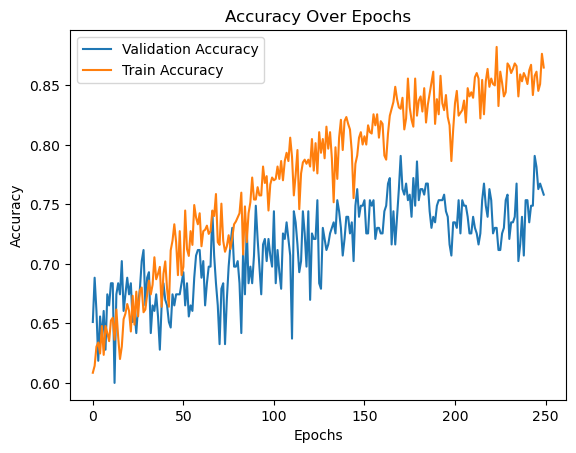

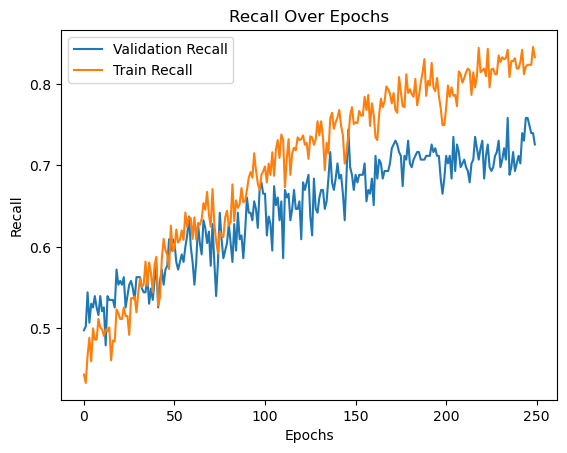

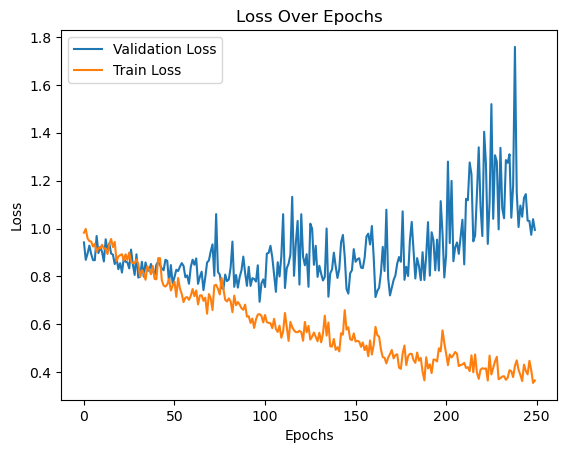

In [422]:
visualize_training_results(mod_8_D_results)

LOOKING FOR TRAING TO FLASTTEN OUT ADJUSTED THE AUGMENTAION WILL ADJUST THE DROPOUT TO .20
will work off the 

In [427]:
mod_8_e= tf.keras.models.Sequential([
       tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
       tf.keras.layers.MaxPooling2D(2, 2),
       tf.keras.layers.Conv2D(32, 3, padding='Same', activation='relu'),
       tf.keras.layers.MaxPooling2D(2, 2),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(150, activation='relu'),
       tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
mod_8_e.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


mod_8_e.summary()

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_97 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_98 (Conv2D)          (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 flatten_63 (Flatten)        (None, 43808)             0         
                                                                 
 dense_134 (Dense)           (None, 150)             

In [428]:
mod_8_e_results = mod_8_e.fit(train_generator_aug, epochs = 150, validation_data = validation_generator_aug)

Epoch 1/150


2022-12-24 12:44:20.221376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 1.7514 - accuracy: 0.2009 - recall: 0.0046 - auc: 0.5348 - prc: 0.2129

2022-12-24 12:44:32.096464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 14s 473ms/step - loss: 1.7514 - accuracy: 0.2009 - recall: 0.0046 - auc: 0.5348 - prc: 0.2129 - val_loss: 1.5966 - val_accuracy: 0.2744 - val_recall: 0.0000e+00 - val_auc: 0.5633 - val_prc: 0.2405
Epoch 2/150
28/28 [==============================] - 13s 442ms/step - loss: 1.6045 - accuracy: 0.2356 - recall: 0.0000e+00 - auc: 0.5428 - prc: 0.2177 - val_loss: 1.5916 - val_accuracy: 0.2698 - val_recall: 0.0000e+00 - val_auc: 0.5506 - val_prc: 0.2485
Epoch 3/150
28/28 [==============================] - 12s 440ms/step - loss: 1.5929 - accuracy: 0.2552 - recall: 0.0035 - auc: 0.5758 - prc: 0.2491 - val_loss: 1.5803 - val_accuracy: 0.2651 - val_recall: 0.0047 - val_auc: 0.5844 - val_prc: 0.2824
Epoch 4/150
28/28 [==============================] - 13s 445ms/step - loss: 1.5930 - accuracy: 0.2483 - recall: 0.0092 - auc: 0.5668 - prc: 0.2404 - val_loss: 1.7197 - val_accuracy: 0.2465 - val_recall: 0.0419 - val_auc: 0.5614 - val_prc: 0.2310
Epoch 5/150
28/2

28/28 [==============================] - 13s 450ms/step - loss: 1.4365 - accuracy: 0.3776 - recall: 0.0797 - auc: 0.7017 - prc: 0.4026 - val_loss: 1.3857 - val_accuracy: 0.4140 - val_recall: 0.0837 - val_auc: 0.7434 - val_prc: 0.4152
Epoch 68/150
28/28 [==============================] - 13s 438ms/step - loss: 1.4055 - accuracy: 0.4157 - recall: 0.1016 - auc: 0.7191 - prc: 0.4382 - val_loss: 1.3935 - val_accuracy: 0.4140 - val_recall: 0.1256 - val_auc: 0.7473 - val_prc: 0.4190
Epoch 69/150
28/28 [==============================] - 13s 454ms/step - loss: 1.3965 - accuracy: 0.3984 - recall: 0.1166 - auc: 0.7258 - prc: 0.4319 - val_loss: 1.3649 - val_accuracy: 0.4093 - val_recall: 0.1535 - val_auc: 0.7507 - val_prc: 0.4404
Epoch 70/150
28/28 [==============================] - 13s 445ms/step - loss: 1.4382 - accuracy: 0.3707 - recall: 0.1074 - auc: 0.7019 - prc: 0.4059 - val_loss: 1.3490 - val_accuracy: 0.4465 - val_recall: 0.1070 - val_auc: 0.7616 - val_prc: 0.4557
Epoch 71/150
28/28 [=====

28/28 [==============================] - 13s 467ms/step - loss: 1.2060 - accuracy: 0.5300 - recall: 0.2864 - auc: 0.8079 - prc: 0.5714 - val_loss: 1.2377 - val_accuracy: 0.4558 - val_recall: 0.2465 - val_auc: 0.8009 - val_prc: 0.5239
Epoch 134/150
28/28 [==============================] - 13s 457ms/step - loss: 1.2249 - accuracy: 0.5092 - recall: 0.3002 - auc: 0.8072 - prc: 0.5471 - val_loss: 1.1239 - val_accuracy: 0.5628 - val_recall: 0.3767 - val_auc: 0.8373 - val_prc: 0.5907
Epoch 135/150
28/28 [==============================] - 13s 459ms/step - loss: 1.1580 - accuracy: 0.5162 - recall: 0.2933 - auc: 0.8215 - prc: 0.5866 - val_loss: 1.1328 - val_accuracy: 0.5721 - val_recall: 0.3349 - val_auc: 0.8341 - val_prc: 0.5703
Epoch 136/150
28/28 [==============================] - 13s 450ms/step - loss: 1.1943 - accuracy: 0.5046 - recall: 0.2875 - auc: 0.8124 - prc: 0.5659 - val_loss: 1.1972 - val_accuracy: 0.5349 - val_recall: 0.3256 - val_auc: 0.8170 - val_prc: 0.5565
Epoch 137/150
28/28 [=

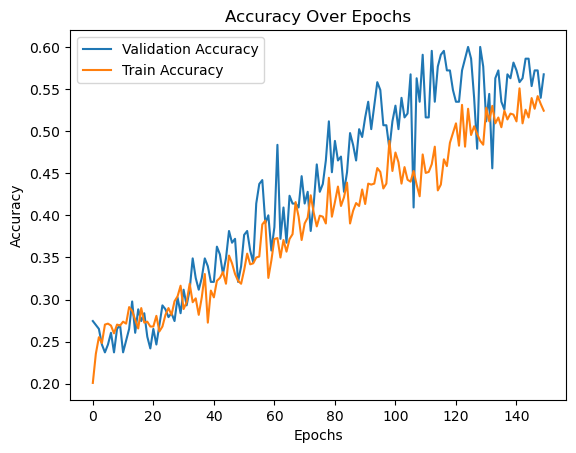

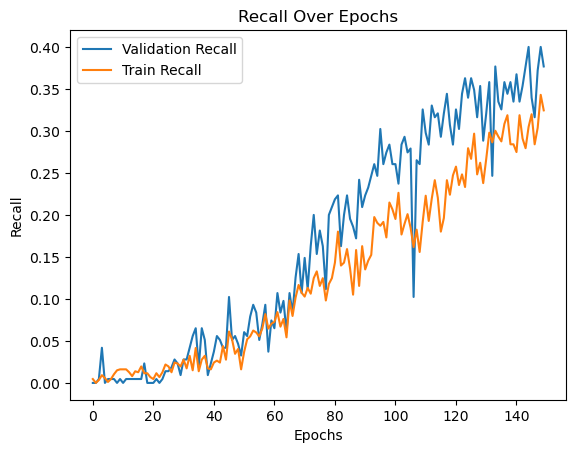

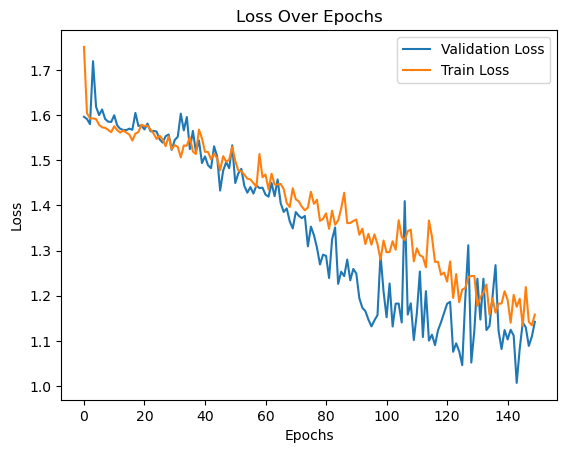

In [429]:
visualize_training_results(mod_8_e_results)

## WORKING OFF THE MODEL_8 

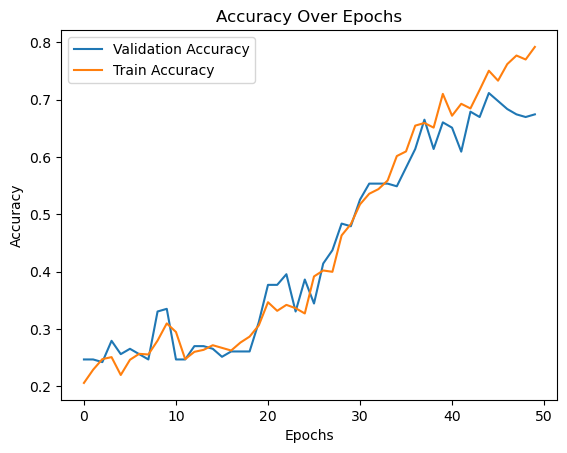

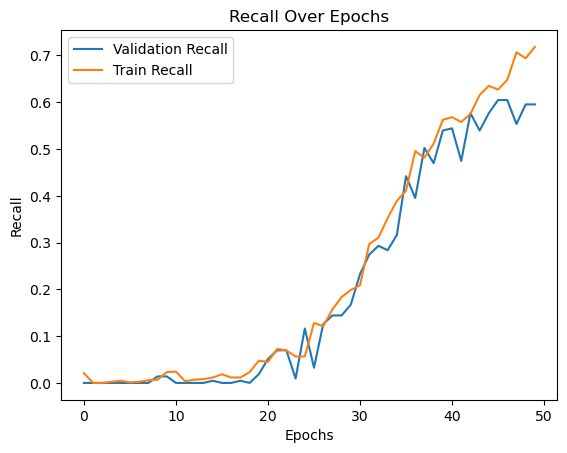

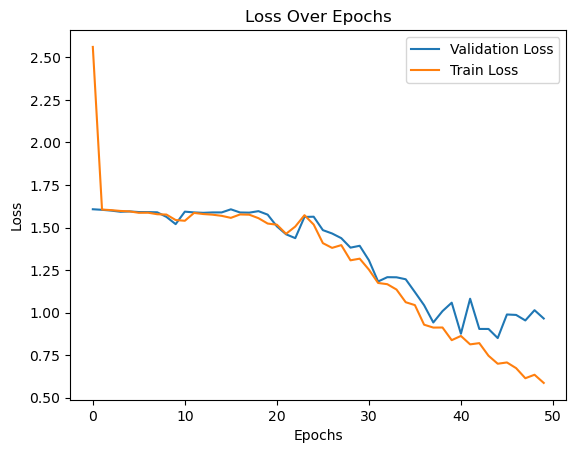

In [321]:
## WORKING OFF THE MODEL_8 
#if you look at val_recall in the begining of iteration it may start off in the negative because data set maybe ordered where negative samples are at the end and positive at 
#begining also added 10 more epochs
visualize_training_results(model8_results)


In [328]:
model10= tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model10.compile(loss='categorical_crossentropy',
            optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


model10.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 flatten_44 (Flatten)        (None, 43808)             0         
                                                                 
 dense_96 (Dense)            (None, 150)             

In [329]:
model10_results = model10.fit(train_generator_aug, epochs = 50, validation_data = validation_generator_aug)

Epoch 1/50


2022-12-23 01:14:56.858507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 1.6473 - accuracy: 0.2344 - recall: 0.0012 - auc: 0.5339 - prc: 0.2127

2022-12-23 01:15:08.926006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 14s 476ms/step - loss: 1.6473 - accuracy: 0.2344 - recall: 0.0012 - auc: 0.5339 - prc: 0.2127 - val_loss: 1.5983 - val_accuracy: 0.2791 - val_recall: 0.0000e+00 - val_auc: 0.5943 - val_prc: 0.2780
Epoch 2/50
28/28 [==============================] - 12s 442ms/step - loss: 1.5890 - accuracy: 0.2575 - recall: 0.0012 - auc: 0.5810 - prc: 0.2432 - val_loss: 1.5141 - val_accuracy: 0.3488 - val_recall: 0.0000e+00 - val_auc: 0.6897 - val_prc: 0.3449
Epoch 3/50
28/28 [==============================] - 12s 443ms/step - loss: 1.5608 - accuracy: 0.2679 - recall: 0.0012 - auc: 0.6238 - prc: 0.2684 - val_loss: 1.4758 - val_accuracy: 0.3907 - val_recall: 0.0047 - val_auc: 0.7097 - val_prc: 0.4017
Epoch 4/50
28/28 [==============================] - 12s 439ms/step - loss: 1.5517 - accuracy: 0.2945 - recall: 0.0115 - auc: 0.6229 - prc: 0.2840 - val_loss: 1.4849 - val_accuracy: 0.3070 - val_recall: 0.0047 - val_auc: 0.6772 - val_prc: 0.3200
Epoch 5/50
28/28 [=====

In [ ]:
"""
model10= tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model10.compile(loss='categorical_crossentropy',
            optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


model10.summary() taking out padding on conv2d for 11







"""

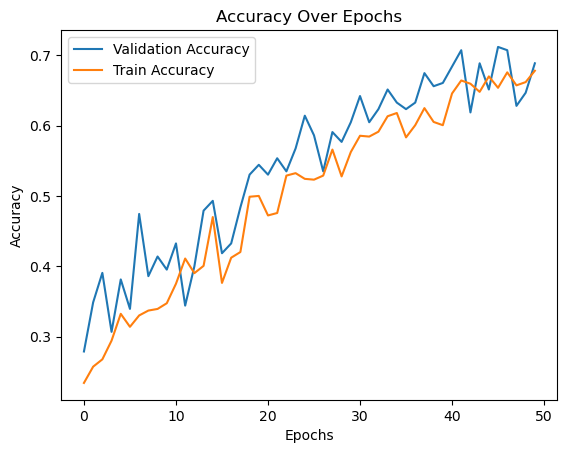

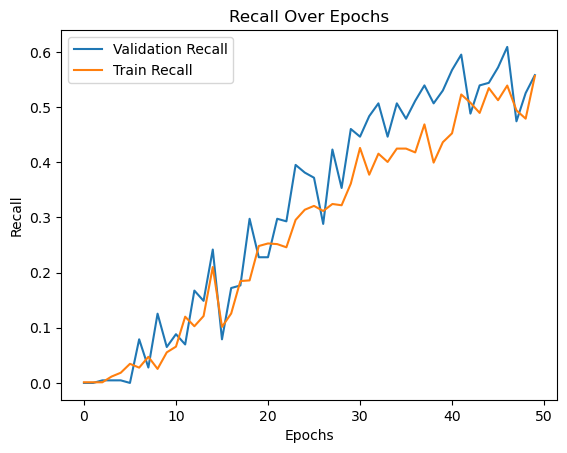

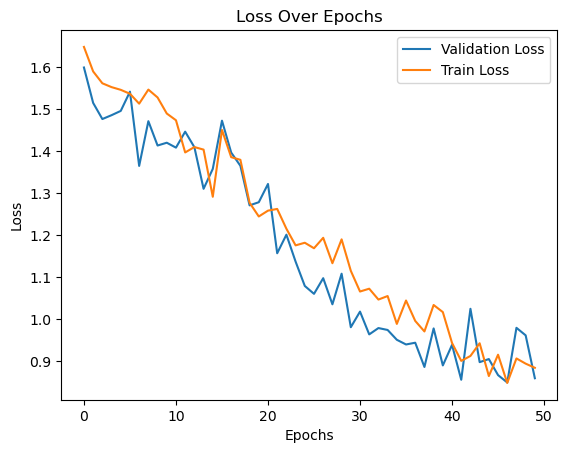

In [330]:
visualize_training_results(model10_results)

In [61]:
train_datagen_aug = ImageDataGenerator(
        #zoom_range=0.2, # zoom
        width_shift_range=0.15,
        #height_shift_range=0.2,
        horizontal_flip=True,# horizontal flip
        #vertical_flip=True,
        #rotation_range=40,
        #shear_range=0.2,
        rescale=1./255, validation_split=0.20)

train_generator_aug = train_datagen_aug.flow_from_directory(
         "DATASET/TRAIN",
        target_size=(150, 150),
        color_mode='rgba',
        batch_size=32,
        class_mode='categorical',
        subset='training',
        seed=7)

validation_datagen_aug = ImageDataGenerator(
        rescale=1./255, validation_split=0.20)

validation_generator_aug = validation_datagen_aug.flow_from_directory(
        "DATASET/TRAIN",
        target_size=(150, 150),
        color_mode='rgba',
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        seed=7)


Found 866 images belonging to 5 classes.
Found 215 images belonging to 5 classes.


In [516]:
# Not sure if I ran this model with .10 or .20
mod_x= tf.keras.models.Sequential([
       tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
       tf.keras.layers.MaxPooling2D(2, 2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Conv2D(128, 3, padding='Same', activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Conv2D(256, 3, padding='Same', activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(1024, activation='relu'),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
mod_x.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


mod_x.summary()

Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_142 (Conv2D)         (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_115 (MaxPooli  (None, 75, 75, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_81 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 conv2d_143 (Conv2D)         (None, 75, 75, 128)       73856     
                                                                 
 max_pooling2d_116 (MaxPooli  (None, 37, 37, 128)      0         
 ng2D)                                                           
                                                                 
 dropout_82 (Dropout)        (None, 37, 37, 128)     

In [476]:
mod_x_results = mod_x.fit(train_generator_aug, epochs = 50, validation_data = validation_generator_aug)

Epoch 1/50


2022-12-29 17:25:33.199604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 3.5544 - accuracy: 0.2587 - recall: 0.0289 - auc: 0.5360 - prc: 0.2228

2022-12-29 17:25:50.838724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 21s 637ms/step - loss: 3.5544 - accuracy: 0.2587 - recall: 0.0289 - auc: 0.5360 - prc: 0.2228 - val_loss: 1.5989 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5629 - val_prc: 0.2363
Epoch 2/50
28/28 [==============================] - 16s 565ms/step - loss: 1.5956 - accuracy: 0.2564 - recall: 0.0000e+00 - auc: 0.5609 - prc: 0.2285 - val_loss: 1.5918 - val_accuracy: 0.2605 - val_recall: 0.0000e+00 - val_auc: 0.5884 - val_prc: 0.2369
Epoch 3/50
28/28 [==============================] - 16s 576ms/step - loss: 1.5844 - accuracy: 0.2898 - recall: 0.0000e+00 - auc: 0.5951 - prc: 0.2483 - val_loss: 1.5459 - val_accuracy: 0.4651 - val_recall: 0.0000e+00 - val_auc: 0.6695 - val_prc: 0.3105
Epoch 4/50
28/28 [==============================] - 16s 563ms/step - loss: 1.5785 - accuracy: 0.3187 - recall: 0.0023 - auc: 0.6347 - prc: 0.2704 - val_loss: 1.5755 - val_accuracy: 0.3349 - val_recall: 0.0000e+00 - val_auc: 0.6251 - val_prc: 0.2731
Epoch 5

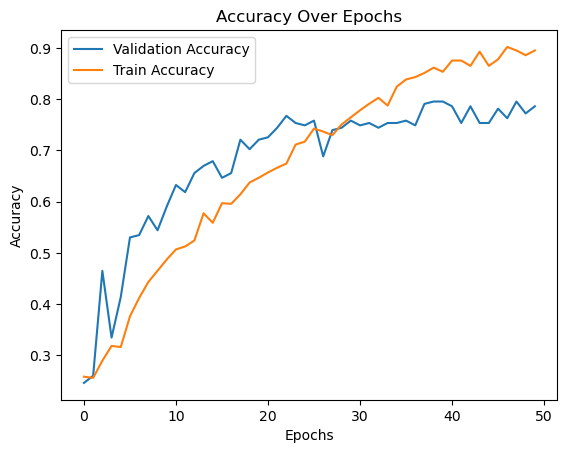

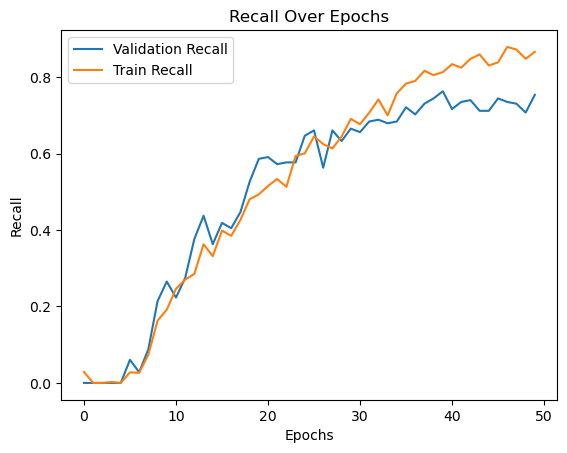

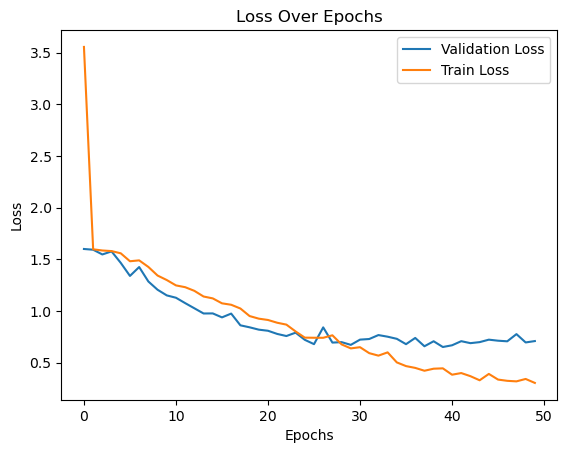

In [477]:
visualize_training_results(mod_x_results)

In [518]:
# this adjusted width+shift to .15
mod_x1= tf.keras.models.Sequential([
       tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
       tf.keras.layers.MaxPooling2D(2, 2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Conv2D(128, 3, padding='Same', activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Conv2D(256, 3, padding='Same', activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(1024, activation='relu'),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
mod_x1.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


mod_x1.summary()

Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_146 (Conv2D)         (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_119 (MaxPooli  (None, 75, 75, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_86 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 conv2d_147 (Conv2D)         (None, 75, 75, 128)       73856     
                                                                 
 max_pooling2d_120 (MaxPooli  (None, 37, 37, 128)      0         
 ng2D)                                                           
                                                                 
 dropout_87 (Dropout)        (None, 37, 37, 128)     

In [519]:
mod_x1_results = mod_x1.fit(train_generator_aug, epochs = 50, validation_data = validation_generator_aug)

Epoch 1/50


2023-01-03 15:12:51.791084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 1.9624 - accuracy: 0.2483 - recall: 0.0208 - auc: 0.5334 - prc: 0.2222

2023-01-03 15:13:05.527759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 16s 534ms/step - loss: 1.9624 - accuracy: 0.2483 - recall: 0.0208 - auc: 0.5334 - prc: 0.2222 - val_loss: 1.6048 - val_accuracy: 0.2326 - val_recall: 0.0000e+00 - val_auc: 0.5583 - val_prc: 0.2289
Epoch 2/50
28/28 [==============================] - 14s 478ms/step - loss: 1.5954 - accuracy: 0.2413 - recall: 0.0000e+00 - auc: 0.5622 - prc: 0.2278 - val_loss: 1.5910 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5825 - val_prc: 0.2367
Epoch 3/50
28/28 [==============================] - 14s 481ms/step - loss: 1.5775 - accuracy: 0.3060 - recall: 0.0000e+00 - auc: 0.6102 - prc: 0.2575 - val_loss: 1.5224 - val_accuracy: 0.4558 - val_recall: 0.0000e+00 - val_auc: 0.7164 - val_prc: 0.3728
Epoch 4/50
28/28 [==============================] - 14s 494ms/step - loss: 1.4922 - accuracy: 0.3857 - recall: 0.0208 - auc: 0.6900 - prc: 0.3423 - val_loss: 1.3112 - val_accuracy: 0.5349 - val_recall: 0.0930 - val_auc: 0.7915 - val_prc: 0.5385
Epoch 5/50


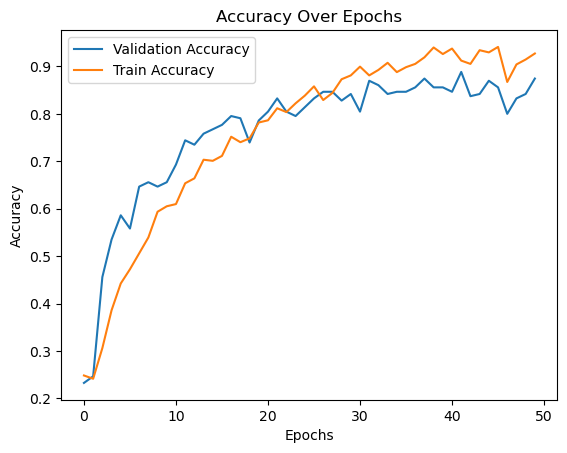

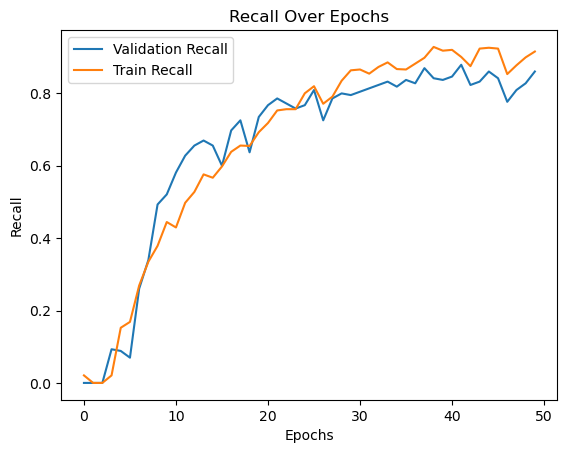

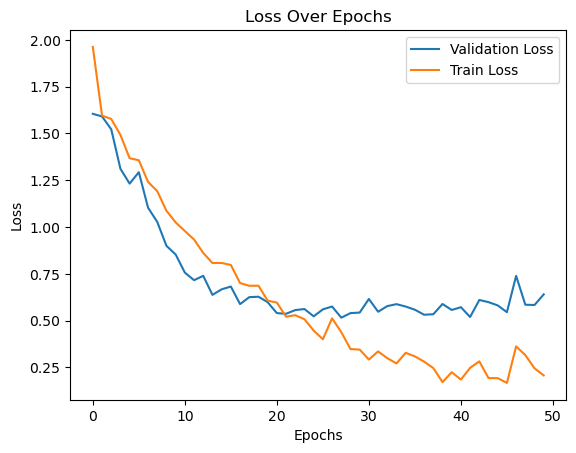

In [520]:
visualize_training_results(mod_x1_results)

"""slighly changed the range on width_scale to .10 instead of .15 trying to bring down the training score  and lift the val score seems like im hitting a wall with the validation score"""


In [62]:
mod_x2= tf.keras.models.Sequential([
       tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
       tf.keras.layers.MaxPooling2D(2, 2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Conv2D(128, 3, padding='Same', activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Conv2D(256, 3, padding='Same', activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(1024, activation='relu'),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
mod_x2.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


mod_x2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 128)      

In [63]:
mod_x2_results = mod_x2.fit(train_generator_aug, epochs = 200, validation_data = validation_generator_aug)

Epoch 1/200


2023-01-03 18:48:58.391688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 1.9062 - accuracy: 0.2367 - recall: 0.0242 - auc: 0.5422 - prc: 0.2234

2023-01-03 18:49:10.880405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 15s 519ms/step - loss: 1.9062 - accuracy: 0.2367 - recall: 0.0242 - auc: 0.5422 - prc: 0.2234 - val_loss: 1.6005 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5636 - val_prc: 0.2242
Epoch 2/200
28/28 [==============================] - 14s 494ms/step - loss: 1.5996 - accuracy: 0.2529 - recall: 0.0000e+00 - auc: 0.5502 - prc: 0.2250 - val_loss: 1.5913 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5836 - val_prc: 0.2343
Epoch 3/200
28/28 [==============================] - 13s 468ms/step - loss: 1.5954 - accuracy: 0.2390 - recall: 0.0000e+00 - auc: 0.5695 - prc: 0.2291 - val_loss: 1.5816 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.6041 - val_prc: 0.2522
Epoch 4/200
28/28 [==============================] - 13s 467ms/step - loss: 1.5769 - accuracy: 0.2760 - recall: 0.0000e+00 - auc: 0.5971 - prc: 0.2565 - val_loss: 1.5560 - val_accuracy: 0.3163 - val_recall: 0.0000e+00 - val_auc: 0.6570 - val_prc: 0.3035


28/28 [==============================] - 14s 500ms/step - loss: 0.3067 - accuracy: 0.8868 - recall: 0.8672 - auc: 0.9877 - prc: 0.9604 - val_loss: 0.4961 - val_accuracy: 0.8465 - val_recall: 0.7953 - val_auc: 0.9690 - val_prc: 0.9158
Epoch 35/200
28/28 [==============================] - 14s 480ms/step - loss: 0.2886 - accuracy: 0.8891 - recall: 0.8626 - auc: 0.9891 - prc: 0.9643 - val_loss: 0.4805 - val_accuracy: 0.8419 - val_recall: 0.8093 - val_auc: 0.9710 - val_prc: 0.9209
Epoch 36/200
28/28 [==============================] - 14s 511ms/step - loss: 0.3665 - accuracy: 0.8695 - recall: 0.8499 - auc: 0.9820 - prc: 0.9472 - val_loss: 0.4910 - val_accuracy: 0.8233 - val_recall: 0.7860 - val_auc: 0.9699 - val_prc: 0.9119
Epoch 37/200
28/28 [==============================] - 15s 507ms/step - loss: 0.2804 - accuracy: 0.9042 - recall: 0.8741 - auc: 0.9891 - prc: 0.9652 - val_loss: 0.4795 - val_accuracy: 0.8279 - val_recall: 0.8140 - val_auc: 0.9734 - val_prc: 0.9241
Epoch 38/200
28/28 [=====

28/28 [==============================] - 14s 493ms/step - loss: 0.1530 - accuracy: 0.9446 - recall: 0.9376 - auc: 0.9951 - prc: 0.9854 - val_loss: 0.5221 - val_accuracy: 0.8651 - val_recall: 0.8419 - val_auc: 0.9695 - val_prc: 0.9280
Epoch 68/200
28/28 [==============================] - 14s 508ms/step - loss: 0.1150 - accuracy: 0.9688 - recall: 0.9630 - auc: 0.9957 - prc: 0.9881 - val_loss: 0.5778 - val_accuracy: 0.8279 - val_recall: 0.8279 - val_auc: 0.9719 - val_prc: 0.9285
Epoch 69/200
28/28 [==============================] - 14s 502ms/step - loss: 0.1270 - accuracy: 0.9630 - recall: 0.9573 - auc: 0.9969 - prc: 0.9903 - val_loss: 0.6269 - val_accuracy: 0.8186 - val_recall: 0.8140 - val_auc: 0.9651 - val_prc: 0.9141
Epoch 70/200
28/28 [==============================] - 14s 501ms/step - loss: 0.1202 - accuracy: 0.9596 - recall: 0.9515 - auc: 0.9980 - prc: 0.9928 - val_loss: 0.6340 - val_accuracy: 0.8651 - val_recall: 0.8465 - val_auc: 0.9628 - val_prc: 0.9178
Epoch 71/200
28/28 [=====

28/28 [==============================] - 15s 515ms/step - loss: 0.0468 - accuracy: 0.9873 - recall: 0.9873 - auc: 0.9996 - prc: 0.9986 - val_loss: 0.6726 - val_accuracy: 0.8326 - val_recall: 0.8326 - val_auc: 0.9682 - val_prc: 0.9298
Epoch 101/200
28/28 [==============================] - 15s 508ms/step - loss: 0.0483 - accuracy: 0.9861 - recall: 0.9827 - auc: 0.9983 - prc: 0.9953 - val_loss: 0.6090 - val_accuracy: 0.8419 - val_recall: 0.8326 - val_auc: 0.9695 - val_prc: 0.9333
Epoch 102/200
28/28 [==============================] - 14s 504ms/step - loss: 0.0542 - accuracy: 0.9873 - recall: 0.9861 - auc: 0.9983 - prc: 0.9961 - val_loss: 0.6190 - val_accuracy: 0.8465 - val_recall: 0.8419 - val_auc: 0.9714 - val_prc: 0.9358
Epoch 103/200
28/28 [==============================] - 14s 514ms/step - loss: 0.1288 - accuracy: 0.9573 - recall: 0.9538 - auc: 0.9974 - prc: 0.9921 - val_loss: 0.7146 - val_accuracy: 0.8512 - val_recall: 0.8419 - val_auc: 0.9547 - val_prc: 0.9020
Epoch 104/200
28/28 [=

28/28 [==============================] - 14s 528ms/step - loss: 0.0700 - accuracy: 0.9850 - recall: 0.9850 - auc: 0.9975 - prc: 0.9930 - val_loss: 0.6991 - val_accuracy: 0.8512 - val_recall: 0.8512 - val_auc: 0.9689 - val_prc: 0.9290
Epoch 134/200
28/28 [==============================] - 15s 510ms/step - loss: 0.0741 - accuracy: 0.9781 - recall: 0.9769 - auc: 0.9988 - prc: 0.9961 - val_loss: 0.6143 - val_accuracy: 0.8558 - val_recall: 0.8558 - val_auc: 0.9669 - val_prc: 0.9210
Epoch 135/200
28/28 [==============================] - 15s 523ms/step - loss: 0.0450 - accuracy: 0.9838 - recall: 0.9838 - auc: 0.9997 - prc: 0.9989 - val_loss: 0.6237 - val_accuracy: 0.8651 - val_recall: 0.8605 - val_auc: 0.9718 - val_prc: 0.9327
Epoch 136/200
28/28 [==============================] - 15s 528ms/step - loss: 0.0544 - accuracy: 0.9815 - recall: 0.9815 - auc: 0.9996 - prc: 0.9983 - val_loss: 0.6323 - val_accuracy: 0.8558 - val_recall: 0.8512 - val_auc: 0.9661 - val_prc: 0.9185
Epoch 137/200
28/28 [=

28/28 [==============================] - 15s 516ms/step - loss: 0.0464 - accuracy: 0.9827 - recall: 0.9827 - auc: 0.9997 - prc: 0.9988 - val_loss: 0.6994 - val_accuracy: 0.8465 - val_recall: 0.8372 - val_auc: 0.9693 - val_prc: 0.9224
Epoch 167/200
28/28 [==============================] - 15s 530ms/step - loss: 0.0471 - accuracy: 0.9861 - recall: 0.9861 - auc: 0.9991 - prc: 0.9974 - val_loss: 0.6538 - val_accuracy: 0.8698 - val_recall: 0.8605 - val_auc: 0.9676 - val_prc: 0.9197
Epoch 168/200
28/28 [==============================] - 15s 532ms/step - loss: 0.0418 - accuracy: 0.9827 - recall: 0.9827 - auc: 0.9997 - prc: 0.9990 - val_loss: 0.6781 - val_accuracy: 0.8791 - val_recall: 0.8605 - val_auc: 0.9686 - val_prc: 0.9268
Epoch 169/200
28/28 [==============================] - 15s 519ms/step - loss: 0.0649 - accuracy: 0.9838 - recall: 0.9827 - auc: 0.9968 - prc: 0.9912 - val_loss: 0.6427 - val_accuracy: 0.8512 - val_recall: 0.8512 - val_auc: 0.9675 - val_prc: 0.9263
Epoch 170/200
28/28 [=

28/28 [==============================] - 15s 526ms/step - loss: 0.0209 - accuracy: 0.9931 - recall: 0.9931 - auc: 0.9994 - prc: 0.9992 - val_loss: 0.8492 - val_accuracy: 0.8651 - val_recall: 0.8605 - val_auc: 0.9641 - val_prc: 0.9178
Epoch 200/200
28/28 [==============================] - 15s 531ms/step - loss: 0.0412 - accuracy: 0.9885 - recall: 0.9885 - auc: 0.9986 - prc: 0.9971 - val_loss: 0.7695 - val_accuracy: 0.8698 - val_recall: 0.8558 - val_auc: 0.9649 - val_prc: 0.9163


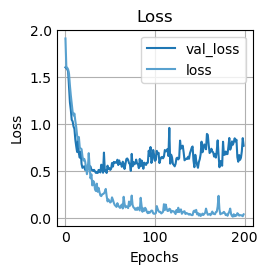

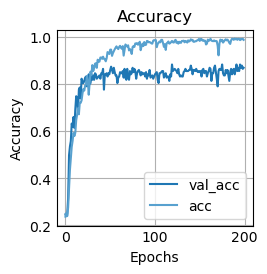

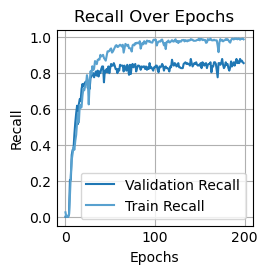

In [134]:
# 200 epochs took 50 min to run
visualize_training_results(mod_x2_results)


In [141]:
mod_x2.evaluate(yoga_test)

15/15 [==============================] - 9s 497ms/step - loss: 0.4578 - accuracy: 0.9170 - recall: 0.9106 - auc: 0.9760 - prc: 0.9470


[0.45775946974754333,
 0.9170212745666504,
 0.9106382727622986,
 0.9760286211967468,
 0.9469608664512634]

# Final Evaluation

In [91]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [92]:

yoga_test = test_datagen.flow_from_directory("DATASET/TEST",
        target_size=(150, 150),
        color_mode='rgba',                                     
        batch_size=32,
        class_mode='categorical',
        shuffle=False                                     
        )
                          

Found 470 images belonging to 5 classes.


In [94]:
predictions = mod_x2.predict(yoga_test)

2023-01-04 12:53:03.103899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 7s 461ms/step


In [135]:
predictions

array([[8.0743551e-01, 1.8385343e-02, 1.6994375e-01, 4.0597888e-03,
        1.7566487e-04],
       [1.0704428e-01, 1.9053857e-01, 6.7837697e-01, 1.0404700e-02,
        1.3635508e-02],
       [8.6076671e-01, 1.8778967e-02, 1.1468627e-01, 5.1899753e-03,
        5.7814532e-04],
       ...,
       [1.8231081e-02, 4.9977693e-01, 4.0051791e-01, 1.6117024e-03,
        7.9862304e-02],
       [1.4751423e-03, 2.3103650e-01, 4.1296229e-02, 2.8928852e-04,
        7.2590292e-01],
       [5.9030385e-04, 7.0307045e-03, 1.2134806e-02, 1.1876471e-01,
        8.6147946e-01]], dtype=float32)

In [136]:
y_pred = np.argmax(predictions, axis = 1)
print(len(y_pred))


470


In [137]:
y_test = yoga_test.classes
print(len(y_test))


470


# Confusion Matrix

In [138]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [127]:
cf_matrix = confusion_matrix(y_test, y_pred)


In [139]:
confusion_matrix(y_test, y_pred)

array([[ 44,   1,  50,   0,   2],
       [  3,  13,  43,   4,  17],
       [  5,   2, 102,   4,   2],
       [  1,   2,  31,  27,   8],
       [  2,  24,  39,   0,  44]])

In [140]:
labels = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']

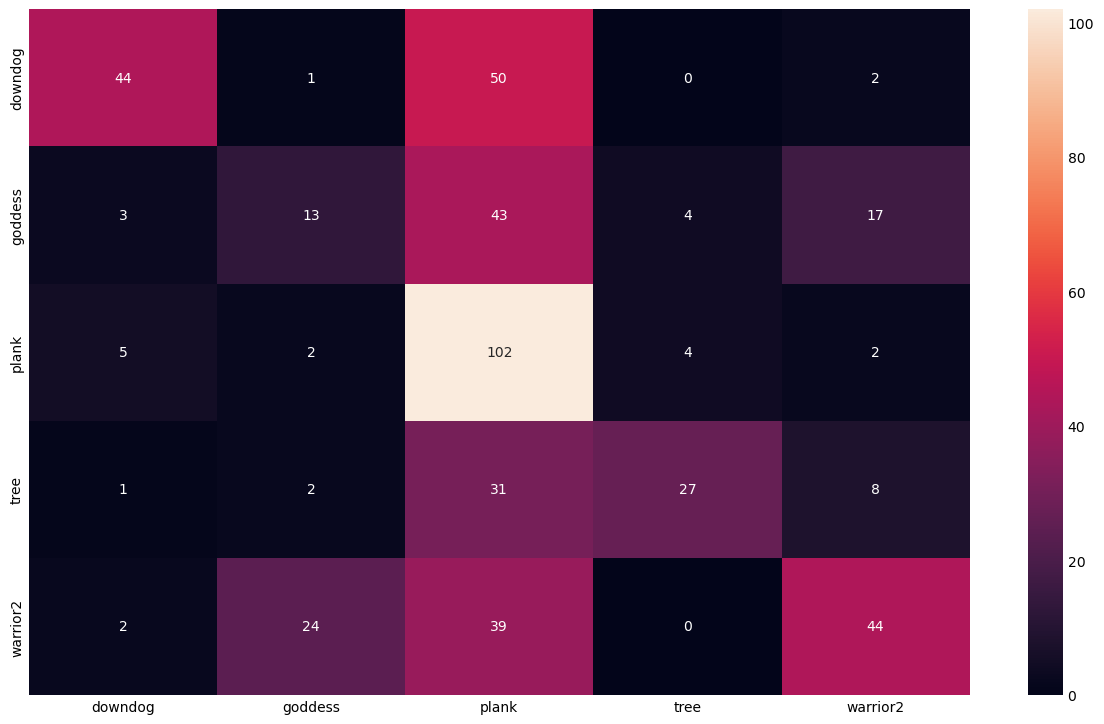

In [132]:
df_cm2 = pd.DataFrame(cf_matrix)
plt.figure(figsize = (12,7));
sns.heatmap(cf_matrix, annot=True, fmt='', xticklabels=labels, yticklabels=labels);
plt.xticks(rotation=0)
plt.show()

In [ ]:
y_pred2 = np.around(model.predict(x_test))
print(metrics.classificastion_report(y_test, y_pred))

# Recommendations and conclusions for

# Future Investigations

In [78]:
import numpy as np
import matplotlib.pyplot as plt

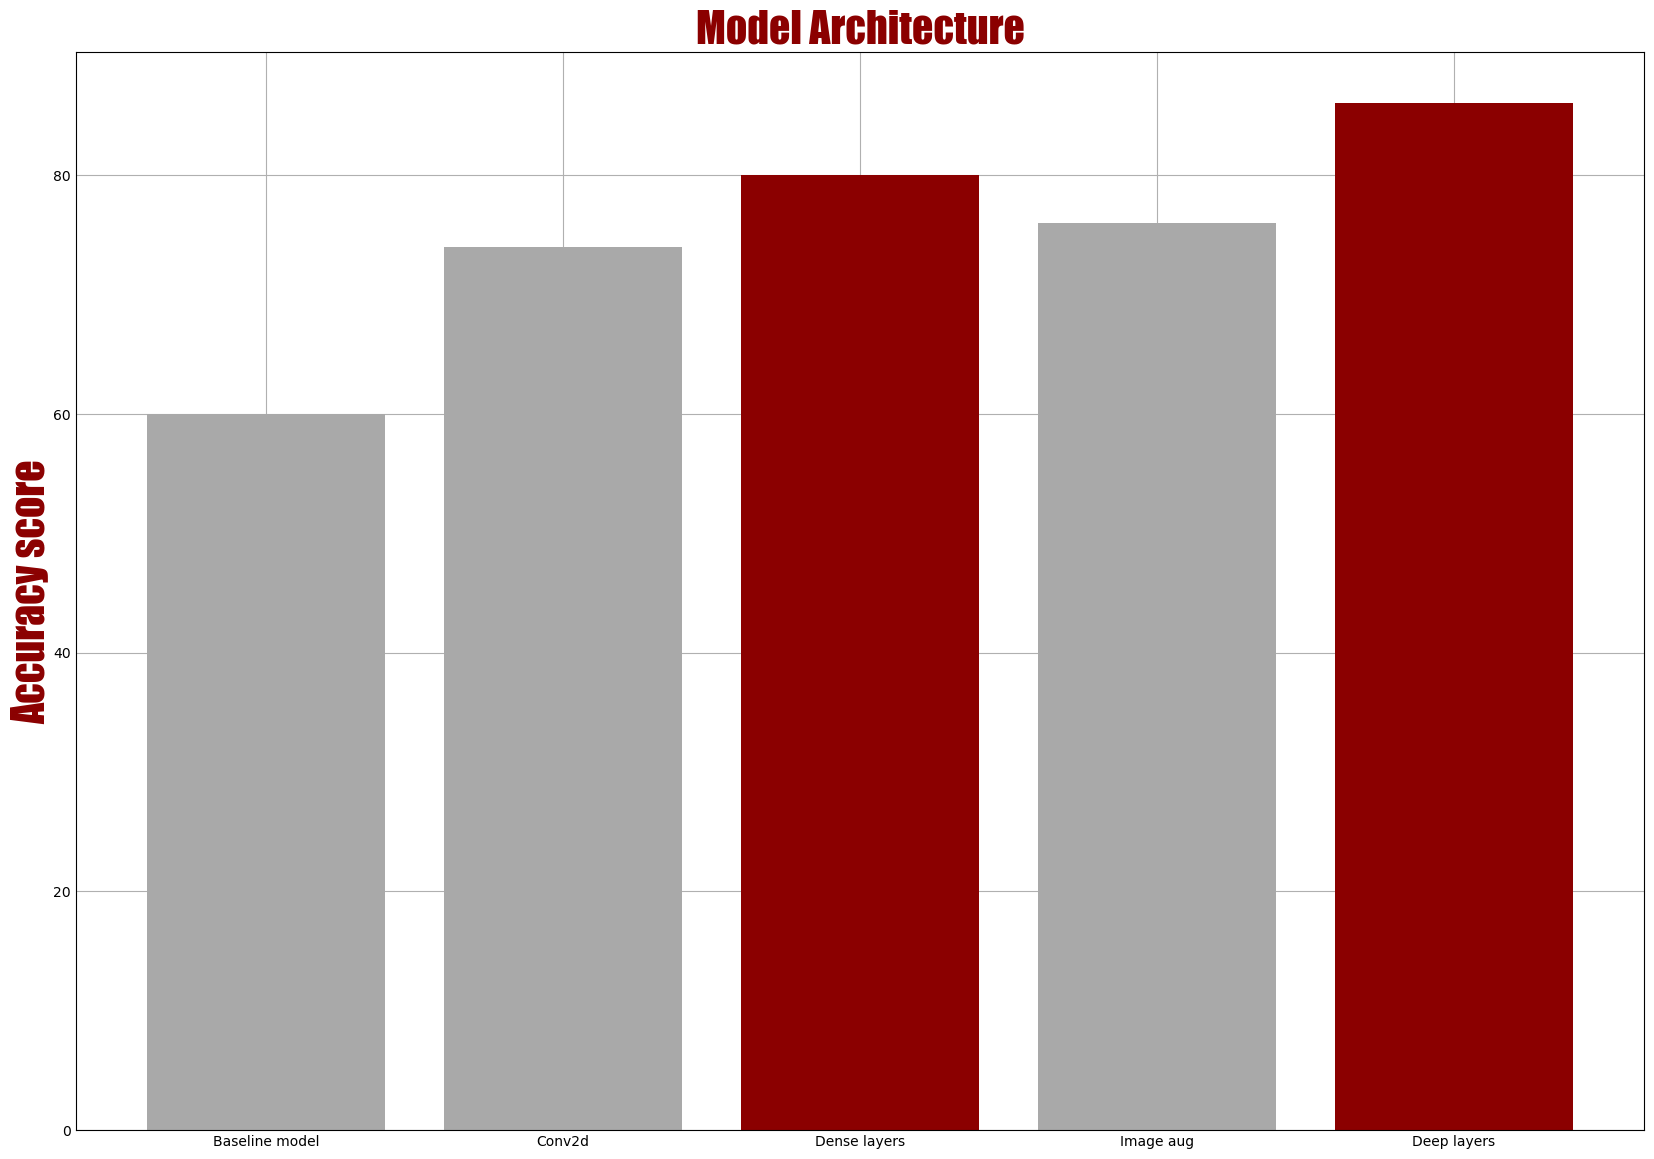

In [89]:
fig, ax = plt.subplots(figsize=(16, 11))


height = [60, 74, 80, 76, 86]

bars = ('Baseline model', 'Conv2d', 'Dense layers', 'Image aug', 'Deep layers')
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height, color=('darkgrey', 'darkgrey','darkred', 'darkgrey', 'darkred'))


# Create names on the x-axis
plt.xticks(y_pos, bars)
#font properties
font1 = {'family':'fantasy','color':'darkred','size':30}

# Label x, y and title
ax.set_title('Model Architecture',fontdict= font1)
ax.set_ylabel('Accuracy score',fontdict= font1)


# Show graphic
plt.show()